<a href="https://colab.research.google.com/github/a-kolodziej-da/sales-analysis-for-online-store/blob/main/Sales_analysis_for_an_online_store_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SALES ANALYSIS FOR ONLINE STORE

https://public.tableau.com/views/project_17646072084190/Dashboard1?:language=fr-FR&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

# Loading data from the database



In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

# Authentication
auth.authenticate_user()

# Creating a BigQuery client
client = bigquery.Client(project="data-analytics-mate")

# SQL query
query = """
SELECT
  browser,
  count(ga_session_id) AS session_cnt
FROM
  `data-analytics-mate.DA.session_params`
GROUP BY
  browser
ORDER BY
  session_cnt DESC
"""

# Executing the query
query_job = client.query(query)
results = query_job.result()

# Converting the results to a DataFrame
df = results.to_dataframe()

# Displaying the result
df.head()



,browser,session_cnt
0,Chrome,238460
1,Safari,83254
2,<Other>,8930
3,Edge,8023
4,Firefox,6433


# BigQuery Data Extraction and Integration (ETL/ELT).

## Data Structure and Content Analysis:
*  Total Number of Columns: **17 columns**.

*  Number of Numerical Columns: **4 numerical columns**: session_id, account_id, is_email_verified (type Int64), price (type float64).

*  Number of Categorical Columns: **11 categorical columns** - geography (continent, country), technology attributes (device, browser, device_model_name, operating_system, browser_language), indicators (product_category, product_name, short_description), traffic_source.

*  Number of** Date Columns**: One column: **session_date**.

*  Number of Unique Sessions: **349,545**. Each row represents a unique analytical unit (session or order).

*  **Period Covered**: The data covers a full range of 92 days, **from 2020-11-01 to 2021-01-31**.

*  Are Missing Values Present: Yes, they are present (in 8 of 17 columns) and are an intentional result of the SQL join logic.

## Key Missing Values and Rationale:
*  Account Columns (account_id, is_email_verified, is_subscribed): 92.01% Missing.

   These missing values are the Guest User Indicator. They signify that over 92% of traffic was conducted without a login.

*  Product Columns (product_category, catalog_price, etc.): 90.41% Missing.

   These missing values are the Abandonment / Non-Conversion Indicator. They signify that over 90% of sessions did not result in an order.

*  browser_language: 32.69% Missing.

   Likely a data quality error (loss of language information) during the collection phase.

In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

# 1. CONFIGURATION
PROJECT_ID = "data-analytics-mate"
DATASET_ID = "DA"

SESSION_PARAMS_TABLE = "session_params"
SESSION_TABLE = "session"
ORDER_TABLE = "order"
ACCOUNT_SESSION_TABLE = "account_session"
ACCOUNT_TABLE = "account"
PRODUCT_TABLE = "product"

# 2. AUTHENTICATION AND CLIENT
auth.authenticate_user()
client = bigquery.Client(project=PROJECT_ID)

# 3. SQL QUERY
query = f"""
SELECT

    s.date AS session_date,
    COALESCE(s.ga_session_id, o.ga_session_id) AS session_id,
    sp.continent AS continent,
    sp.country AS country,
    sp.device AS device,
    sp.browser AS browser,
    sp.mobile_model_name AS device_model_name,
    sp.operating_system AS operating_system,
    sp.language AS browser_language,
    sp.medium AS traffic_source,
    acs.account_id AS account_id,
    a.is_verified AS is_email_verified,
    (a.is_unsubscribed = 0) AS is_subscribed,
    p.category AS product_category,
    p.name AS product_name,
    p.price AS price,
    p.short_description AS short_description

FROM
    `{PROJECT_ID}.{DATASET_ID}.{SESSION_TABLE}` AS s
FULL OUTER JOIN
    `{PROJECT_ID}.{DATASET_ID}.{ORDER_TABLE}` AS o
    ON s.ga_session_id = o.ga_session_id

LEFT JOIN
    `{PROJECT_ID}.{DATASET_ID}.{SESSION_PARAMS_TABLE}` AS sp
    ON COALESCE(s.ga_session_id, o.ga_session_id) = sp.ga_session_id

LEFT JOIN
    `{PROJECT_ID}.{DATASET_ID}.{ACCOUNT_SESSION_TABLE}` AS acs
    ON COALESCE(s.ga_session_id, o.ga_session_id) = acs.ga_session_id

LEFT JOIN
    `{PROJECT_ID}.{DATASET_ID}.{ACCOUNT_TABLE}` AS a
    ON acs.account_id = a.id

LEFT JOIN
    `{PROJECT_ID}.{DATASET_ID}.{PRODUCT_TABLE}` AS p
    ON o.item_id = p.item_id
"""

# 4. EXECUTION AND RESULT
query_job = client.query(query)
df_results = query_job.to_dataframe()

# 5. DISPLAYING RESULTS
print(df_results.head())
print()
df_results.info()


# 6. DATA QUALITY: MISSING VALUES ANALYSIS
missing_data = df_results.isnull().sum()
total_rows = len(df_results)

# Create a DataFrame containing the count and percentage of missing values
missing_info = pd.DataFrame({
    'Missing Values (Count)': missing_data,
    'Missing Percentage (%)': (missing_data / total_rows) * 100})
missing_info['Missing Percentage (%)'] = missing_info['Missing Percentage (%)'].map('{:.2f}%'.format)
missing_info_filtered = missing_info[missing_info['Missing Values (Count)'] > 0].sort_values(
    by='Missing Values (Count)', ascending=False)

print("\n--- DATA QUALITY: MISSING VALUES ANALYSIS ---")
print(f"Total number of rows in the dataset: {total_rows}")
print("\nColumns containing missing values (sorted by highest count):")
print(missing_info_filtered)

# 7. CALCULATE THE MAXIMUM AND MINIMUM SESSION DATES
max_date = df_results['session_date'].max()
min_date = df_results['session_date'].min()

# Calculate the total number of days covered by the data
date_range_days = (max_date - min_date).days + 1

# Display the result in a clean, informative format
print("\n--- DATE RANGE ANALYSIS ---")
print(f"Earliest Date in Dataset (Min Date): {min_date.strftime('%Y-%m-%d')}")
print(f"Latest Date in Dataset (Max Date): {max_date.strftime('%Y-%m-%d')}")
print(f"Total Coverage Period: {date_range_days} days")



  session_date  session_id continent         country   device browser  \
0   2020-11-01  5760483956  Americas   United States  desktop  Chrome   
1   2020-11-01  7115337200    Europe  United Kingdom  desktop  Chrome   
2   2020-11-01  3978035233    Europe          Norway   mobile  Chrome   
3   2020-11-01  9648986282    Africa         Nigeria   mobile  Chrome   
4   2020-11-01  4393441533      Asia           China  desktop  Chrome   

  device_model_name operating_system browser_language traffic_source  \
0            Safari        Macintosh               zh        <Other>   
1            Chrome              Web            en-us        organic   
2           <Other>              Web               zh         (none)   
3           <Other>          Android            es-es         (none)   
4            Chrome          Windows            en-us         (none)   

   account_id  is_email_verified  is_subscribed            product_category  \
0        <NA>               <NA>           <NA>  

# Data Cleaning and Preparation
In the Data Cleaning section, we executed two key processes that prepared the df_results set for robust analysis. All cleaning logic was encapsulated within the clean_data() function, which operates on a data copy, preventing errors upon multiple executions.

1.   Missing data points (NULLs) were replaced with business-meaningful labels, allowing us to use the previously empty fields for segmentation:
*  **Users**: Missing values in the account_id column (92% of rows) were replaced with the label 'GUEST'. Related indicators (is_email_verified, is_subscribed) were filled with False.
*  **Transactions**: Missing values in product columns (product_category, price, etc. – 90% of rows) were replaced with the label 'NO_ORDER' or the numeric value 0.00 for price. This allows empty rows to function as abandoned session indicators.
*  **Data Quality**: Missing values in browser_language (33%) were marked as 'UNKNOWN'.
2.   We ensured all columns have a consistent and correct data type, which is essential for grouping and calculations:
*  **Identifier columns** (session_id, account_id) were explicitly converted to the string type.
*  **The date column** (session_date) was converted to the datetime format.
*  **Logical columns** (is_email_verified, is_subscribed) were converted to the bool type.



In [ ]:
import numpy as np
import pandas as pd

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Args:
        df: The raw DataFrame loaded directly from BigQuery.
    Returns:
        A cleaned DataFrame ready for EDA.
    """
    df_clean = df.copy()

    # 1. LOGICAL IMPUTATION OF NULL VALUES

    # Convert to string first to safely accept 'GUEST'.
    df_clean['account_id'] = df_clean['account_id'].astype(str)

    # Use np.where to replace only the NULL/NA values ('nan' or '<NA>') with 'GUEST'.
    df_clean['account_id'] = np.where(
        (df_clean['account_id'] == 'nan') | (df_clean['account_id'] == '<NA>'),
        'GUEST',
        df_clean['account_id'])

    # FIX for is_email_verified (Int64): Fill with 0, then convert to bool.
    df_clean['is_email_verified'] = df_clean['is_email_verified'].fillna(0).astype(bool)

    # is_subscribed (boolean): Fill with False.
    df_clean['is_subscribed'] = df_clean['is_subscribed'].fillna(False).astype(bool)

    # Handling Product Data (90% Missing)
    product_cols = ['product_category', 'product_name', 'short_description']
    for col in product_cols:
        df_clean[col] = df_clean[col].fillna('NO_ORDER')

    # Price: NULL must be 0.00 for sessions without a transaction.
    df_clean['price'] = df_clean['price'].fillna(0.00)

    # Handling Data Quality Issue
    df_clean['browser_language'] = df_clean['browser_language'].fillna('UNKNOWN')

    # 2. DATA TYPE CASTING FOR CONSISTENCY

    # Convert date column to proper Pandas datetime format
    df_clean['session_date'] = pd.to_datetime(df_clean['session_date'])

    # Convert session ID to string (it's an identifier)
    df_clean['session_id'] = df_clean['session_id'].astype(str)

    return df_clean

# --- EXECUTION ---
df_clean = clean_data(df_results)

print("Data cleaning complete.")
print(df_results.head())
print()
df_clean.info()

Data cleaning complete.
  session_date  session_id continent         country   device browser  \
0   2020-11-01  5760483956  Americas   United States  desktop  Chrome   
1   2020-11-01  7115337200    Europe  United Kingdom  desktop  Chrome   
2   2020-11-01  3978035233    Europe          Norway   mobile  Chrome   
3   2020-11-01  9648986282    Africa         Nigeria   mobile  Chrome   
4   2020-11-01  4393441533      Asia           China  desktop  Chrome   

  device_model_name operating_system browser_language traffic_source  \
0            Safari        Macintosh               zh        <Other>   
1            Chrome              Web            en-us        organic   
2           <Other>              Web               zh         (none)   
3           <Other>          Android            es-es         (none)   
4            Chrome          Windows            en-us         (none)   

   account_id  is_email_verified  is_subscribed            product_category  \
0        <NA>            

# EXPLORATORY AND STRATEGIC ANALYSIS OF E-COMMERCE INDICATORS (EDA & KPI)

## Geographical Analysis of Sales and Orders
*  The market is heavily concentrated in the **Americas**, which generates more revenue than Asia and Europe combined. This presents both an opportunity (strong base market) and a risk (high dependency on a single region).

*  The **Americas** also lead in order volume (18,553), indicating dominance in both **transaction value** and **customer count**.

*  **The United States** is, by far, the most critical market. Almost half of the total sales are generated by a single country.

*  There is a very strong cause-and-effect relationship: the dominance of the **Americas** is largely driven by the dominance of the single country, the **United States**. This means any issues or slowdowns in the US would have an immediate, dramatic impact on global performance.

*  **Value vs. Volume**: The ratio of **Total_Sales** to **Total_Orders** suggests the average order value is higher in the Americas than in other regions (17.6M USD from 18.5k orders vs 5.9M USD from 6.2k orders in Europe). This indicates American customers tend to purchase higher-value products or larger quantities.


--- TOP 3 CONTINENTS BY SALES ---
continent  Total_Sales  Total_Orders
 Americas   17665280.0         18553
     Asia    7601298.3          7950
   Europe    5934624.2          6261

--- TOP 5 COUNTRIES BY SALES ---
       country  Total_Sales  Total_Orders
 United States   13943553.9         14673
         India    2809762.0          3029
        Canada    2437921.0          2560
United Kingdom     938317.9          1029
        France     710692.8           678


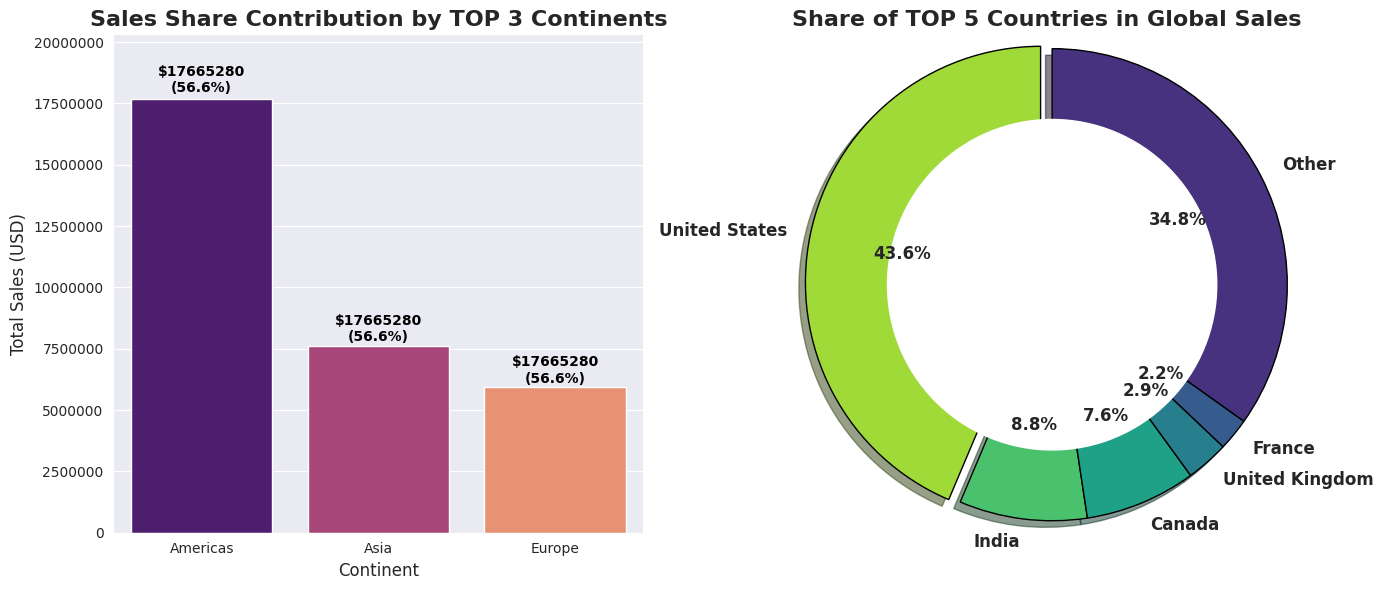

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for only converting sessions (price > 0)
converting_data = df_clean[df_clean['price'] > 0].copy()
total_global_sales = converting_data['price'].sum()

# Continents Analysis
continent_metrics = converting_data.groupby('continent').agg(
    Total_Sales=('price', 'sum'),
    Total_Orders=('session_id', 'size')
).reset_index().sort_values(by='Total_Sales', ascending=False)

top_3_continents = continent_metrics.head(3).copy()

top_3_continents['Sales_Share (%)'] = (top_3_continents['Total_Sales'] / top_3_continents['Total_Sales'].sum()) * 100
print("\n--- TOP 3 CONTINENTS BY SALES ---")
print(top_3_continents[['continent', 'Total_Sales', 'Total_Orders']].head(3).to_string(index=False))

# Countries Analysis
country_metrics = converting_data.groupby('country').agg(
    Total_Sales=('price', 'sum'),
    Total_Orders=('session_id', 'size')
).reset_index().sort_values(by='Total_Sales', ascending=False)

top_5_countries = country_metrics.head(5).copy()

top_5_countries['Sales_Share (%)'] = (top_5_countries['Total_Sales'] / total_global_sales) * 100

print("\n--- TOP 5 COUNTRIES BY SALES ---")
# Display table without index
print(top_5_countries[['country', 'Total_Sales', 'Total_Orders']].to_string(index=False))


# Visualization


# Assuming top_5_countries, total_global_sales, and top_3_continents are already defined
pie_data = top_5_countries.copy()
other_sales = total_global_sales - pie_data['Total_Sales'].sum()
other_share = 100 - pie_data['Sales_Share (%)'].sum()

new_row = pd.DataFrame([['Other', other_sales, 0, other_share]], columns=['country', 'Total_Sales', 'Total_Orders', 'Sales_Share (%)'])
pie_data = pd.concat([pie_data, new_row], ignore_index=True)

# --- Create a figure with two subplots side-by-side (Modern Layout) ---
sns.set_style("darkgrid")
plt.figure(figsize=(14, 6))

# --- Subplot 1: Bar Chart for Top 3 Continents Sales Share (CRISP) ---
plt.subplot(1, 2, 1)
sns.barplot(
    x='continent',
    y='Total_Sales',
    data=top_3_continents,
    palette='magma',
    hue='continent',
    legend=False)
max_sales = top_3_continents['Total_Sales'].max()
plt.ylim(0, max_sales * 1.15)
plt.title('Sales Share Contribution by TOP 3 Continents', fontsize=16, fontweight='bold')
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Total Sales (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)

# Add percentage and value labels centered over bars
for container in plt.gca().containers:
    for i, bar in enumerate(container):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2,
                 height * 1.01,
                 f"${top_3_continents.iloc[i]['Total_Sales']:.0f}\n({top_3_continents.iloc[i]['Sales_Share (%)']:.1f}%)",
                 color='black',
                 ha="center",
                 va="bottom",
                 fontsize=10,
                 fontweight='bold')

# --- Subplot 2: Enhanced Donut Chart for Top 5 Countries Global Sales Share (MODERN) ---
plt.subplot(1, 2, 2) # (rows, columns, plot_number)

# Create the 'explode' array to highlight the largest segment (index 0, usually US)
explode = [0.05] + [0] * (len(pie_data) - 1)

plt.pie(
    pie_data['Sales_Share (%)'],
    labels=pie_data['country'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("viridis_r", len(pie_data)),
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.0, 'antialiased': True},
    textprops={'fontsize': 12, 'fontweight': 'bold'},
    explode=explode,
    shadow=True)

# Drawing a white circle to create the "donut chart" effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Share of TOP 5 Countries in Global Sales', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Analysis of the 10 most popular product categories in terms of total sales.

*  **Dominance of Seating / Lounge Furniture**: Sales are heavily skewed toward seating furniture (Sofas and Chairs). These two categories generate far more revenue than all others, which must dictate inventory and product development strategy.

*  **Customer Pattern**: Customers primarily purchase essential, foundational furniture: seating/sleeping items. Other, more niche categories like Bar furniture and Children's furniture have a marginal share of the total TOP 10 sales.


--- TOP 10 PRODUCT CATEGORIES BY GLOBAL SALES ---
                product_category  Total_Sales  Total_Orders
               Sofas & armchairs    8388254.5          4301
                          Chairs    6147748.8          5952
                            Beds    4919725.0          2926
      Bookcases & shelving units    3640818.1          7630
            Cabinets & cupboards    2336499.5          2318
               Outdoor furniture    2142222.2          2229
                  Tables & desks    1790307.5          2941
Chests of drawers & drawer units     906562.5          1452
                   Bar furniture     735503.0          1092
            Children's furniture     467697.0          1702


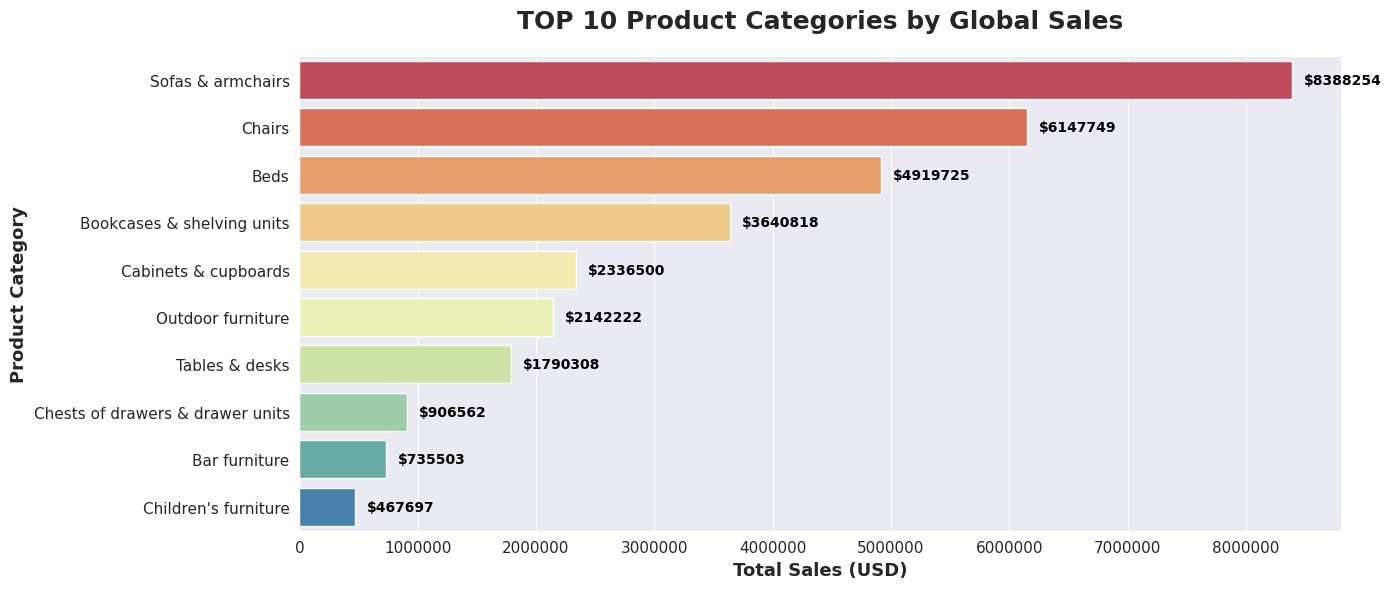

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 10 most popular product categories by total sales (Globally).
category_sales = converting_data.groupby('product_category').agg(
    Total_Sales=('price', 'sum'),
    Total_Orders=('session_id', 'size')
).reset_index().sort_values(by='Total_Sales', ascending=False)

# Create a copy for the top 10 results
top_10_categories = category_sales.head(10).copy()

print("\n--- TOP 10 PRODUCT CATEGORIES BY GLOBAL SALES ---")
print(top_10_categories.to_string(index=False))

# Visualization
sns.set_style("darkgrid")
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x='Total_Sales',
    y='product_category',
    data=top_10_categories,
    palette='Spectral',
    hue='product_category',
    legend=False)
plt.title('TOP 10 Product Categories by Global Sales', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Total Sales (USD)', fontsize=13, fontweight='bold')
plt.ylabel('Product Category', fontsize=13, fontweight='bold')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Add value labels to the bars
for bar in ax.patches:
    x_val = bar.get_width()
    y_val = bar.get_y() + bar.get_height() / 2
    category_index = int(y_val)
    sales_value = top_10_categories.iloc[category_index]['Total_Sales']
    plt.text(x_val + 100000,
             y_val,
             f"${sales_value:.0f}",
             color='black',
             ha="left",
             va="center",
             fontsize=10,
             fontweight='bold')

plt.tight_layout()
plt.show()

## Analysis of the 10 most popular product categories in the country with the highest sales.

*  **The US Market Dictates the Global Product Trend**: The five most popular product categories in the United States are identical (in both category and rank order) to the global TOP 5 list.

*  The US market is not only the largest but also the **primary driver of the company's global product demand**. A product strategy prioritizing Sofas & armchairs, Chairs, and Beds is valid across the entire company.


--- TOP 10 PRODUCT CATEGORIES IN United States (SALES) ---
                product_category  US_Total_Sales  US_Total_Orders
               Sofas & armchairs       3707144.5             1903
                          Chairs       2619773.8             2576
                            Beds       2213058.0             1298
      Bookcases & shelving units       1567606.9             3374
            Cabinets & cupboards        994545.5              995
               Outdoor furniture        929245.2              984
                  Tables & desks        777865.0             1248
Chests of drawers & drawer units        382388.0              616
                   Bar furniture        330805.0              487
            Children's furniture        207575.0              752


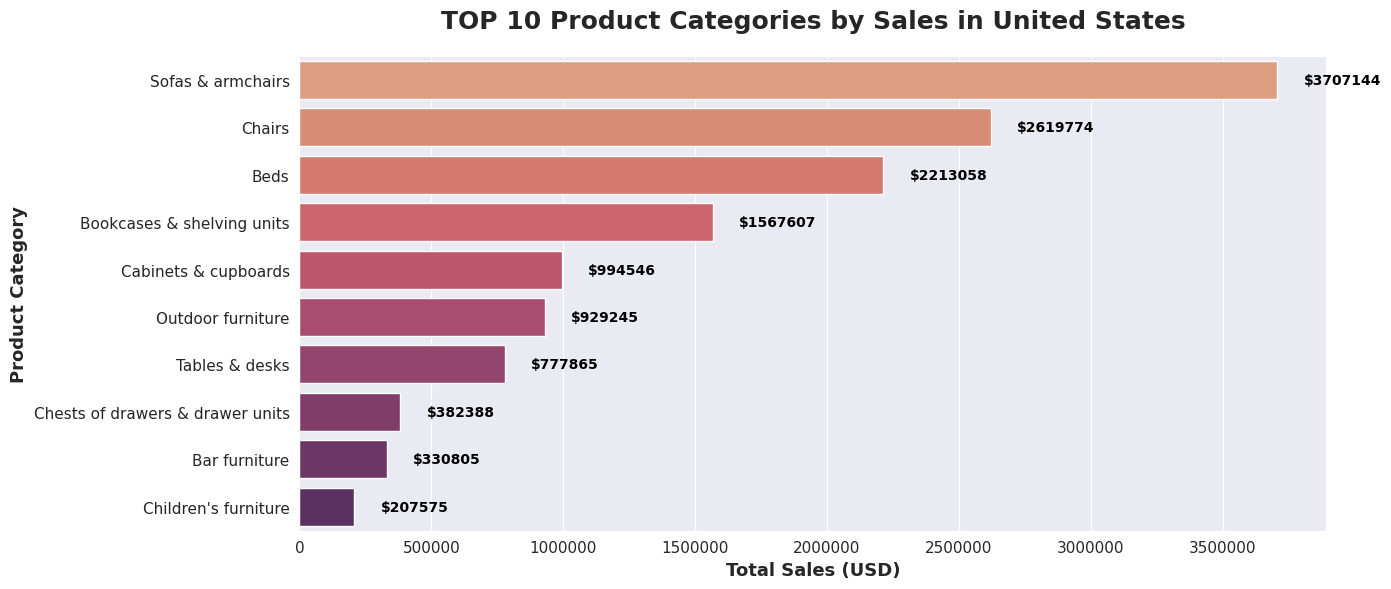

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Identify the Top-Selling Country
country_sales_ranking = converting_data.groupby('country').agg(
    Total_Sales=('price', 'sum')
).reset_index().sort_values(by='Total_Sales', ascending=False)
top_country = country_sales_ranking.iloc[0]['country']

# Data Analysis (Top Country Market)
us_converting_data = converting_data[converting_data['country'] == top_country].copy()

# 10 most popular product categories by total sales in the top country
us_category_sales = us_converting_data.groupby('product_category').agg(
    US_Total_Sales=('price', 'sum'),
    US_Total_Orders=('session_id', 'size')
).reset_index().sort_values(by='US_Total_Sales', ascending=False)
top_10_us_categories = us_category_sales.head(10).copy()

print(f"\n--- TOP 10 PRODUCT CATEGORIES IN {top_country} (SALES) ---")
print(top_10_us_categories.to_string(index=False))


# Visualization
sns.set_style("darkgrid")
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x='US_Total_Sales',
    y='product_category',
    data=top_10_us_categories,
    palette='flare',
    hue='product_category',
    legend=False)
plt.title(f'TOP 10 Product Categories by Sales in {top_country}', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Total Sales (USD)', fontsize=13, fontweight='bold')
plt.ylabel('Product Category', fontsize=13, fontweight='bold')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Add value labels to the bars (using stable positioning)
for bar in ax.patches:
    x_val = bar.get_width()
    y_val = bar.get_y() + bar.get_height() / 2
    category_index = int(y_val)
    sales_value = top_10_us_categories.iloc[category_index]['US_Total_Sales']
    plt.text(x_val + 100000,
             y_val,
             f"${sales_value:.0f}",
             color='black',
             ha="left",
             va="center",
             fontsize=10,
             fontweight='bold')

plt.tight_layout()
plt.show()

## Sales analysis by device types and models.

1.  **Desktop Dominance**: The largest proportion of conversion transactions occurs on desktop computers.

This is likely due to:
*  **High Product Price**: Customers purchasing expensive furniture prefer the larger screen size for detailed product inspection, color checks, and 3D layout visualization.
*  **Completion Comfort**: Finalizing large transactions (payments, delivery addresses) is often perceived as safer and more convenient on a desktop environment.
2.  **Mobile Channel Weakness**: Despite the widespread use of mobile devices, their share of final sales is the lowest.

This suggests that:
*  **Mobile** and **Tablet** users are primarily engaging in browsing and inspiration gathering but switch to a Desktop device to complete the purchase (cross-device behavior).
*  There may be **UX/UI issues** in the mobile checkout process (e.g., non-responsive payment forms, slow loading times) that create friction.




--- SALES SHARE BY DEVICE TYPE (DEVICE) ---
 device Total_Sales Sales_Share (%)
desktop $18,864,039           59.0%
 mobile $12,384,226           38.7%
 tablet    $723,466            2.3%

--- TOP 10 SALES SHARE BY DEVICE MODEL NAME ---
device_model_name Total_Sales Sales_Share (%)
           Chrome  $8,899,524           27.8%
          <Other>  $6,535,331           20.4%
           Safari  $6,491,062           20.3%
           iPhone  $6,420,776           20.1%
       ChromeBook  $1,830,459            5.7%
             Edge    $697,222            2.2%
             iPad    $448,854            1.4%
          Firefox    $421,067            1.3%
       Pixel 4 XL    $118,288            0.4%
          Pixel 3    $109,148            0.3%


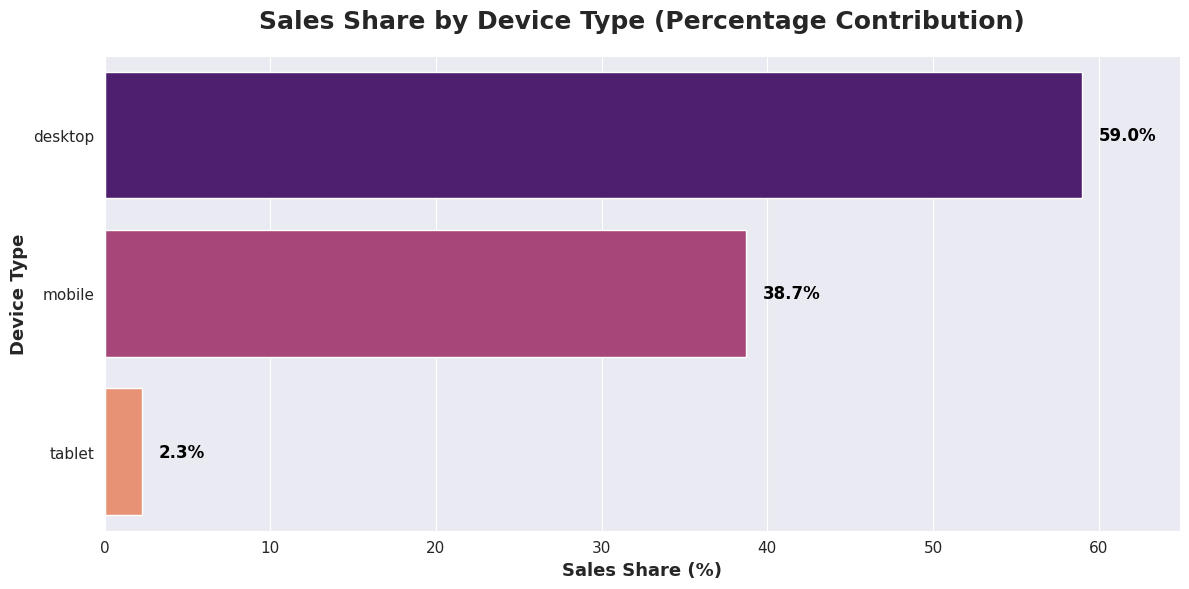

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate global total sales (needed for percentage calculation)
global_total_sales = converting_data['price'].sum()

# Group by the correct column name 'device'
device_type_sales = converting_data.groupby('device').agg(
    Total_Sales=('price', 'sum')
).reset_index().sort_values(by='Total_Sales', ascending=False)

# Calculate percentage of total sales
device_type_sales['Sales_Share (%)'] = (device_type_sales['Total_Sales'] / global_total_sales) * 100
print("\n--- SALES SHARE BY DEVICE TYPE (DEVICE) ---")

device_type_sales_formatted = device_type_sales.copy()
device_type_sales_formatted['Total_Sales'] = device_type_sales_formatted['Total_Sales'].apply(lambda x: f"${x:,.0f}")
device_type_sales_formatted['Sales_Share (%)'] = device_type_sales_formatted['Sales_Share (%)'].round(1).astype(str) + '%'
print(device_type_sales_formatted.to_string(index=False))

# Group by the correct column name 'device_model_name'
device_model_sales = converting_data.groupby('device_model_name').agg(
    Total_Sales=('price', 'sum')
).reset_index().sort_values(by='Total_Sales', ascending=False)
top_10_device_models = device_model_sales.head(10).copy()

# Calculate percentage of total sales
top_10_device_models['Sales_Share (%)'] = (top_10_device_models['Total_Sales'] / global_total_sales) * 100
print("\n--- TOP 10 SALES SHARE BY DEVICE MODEL NAME ---")
top_10_device_models_formatted = top_10_device_models.copy()
top_10_device_models_formatted['Total_Sales'] = top_10_device_models_formatted['Total_Sales'].apply(lambda x: f"${x:,.0f}")
top_10_device_models_formatted['Sales_Share (%)'] = top_10_device_models_formatted['Sales_Share (%)'].round(1).astype(str) + '%'
print(top_10_device_models_formatted.to_string(index=False))


# Visualization

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='Sales_Share (%)',
    y='device',
    data=device_type_sales,
    palette='magma',
    hue='device',
    legend=False)
plt.title('Sales Share by Device Type (Percentage Contribution)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Sales Share (%)', fontsize=13, fontweight='bold')
plt.ylabel('Device Type', fontsize=13, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
for bar in ax.patches:
    x_val = bar.get_width()
    y_val = bar.get_y() + bar.get_height() / 2
    percentage = f"{x_val:.1f}%"
    plt.text(x_val + 1.0,
             y_val,
             percentage,
             color='black',
             ha="left",
             va="center",
             fontsize=12,
             fontweight='bold')
plt.xlim(0, device_type_sales['Sales_Share (%)'].max() * 1.1)

plt.tight_layout()
plt.show()

## Sales analysis by traffic source.

1. **Power of Free Traffic (Organic & Brand)**: 34.2% of sales originate from free channels: Organic (SEO). This means the company has a **powerful brand** and excels in organic search results.

2.  **Paid Advertising Alarm (CPC)**: The share of paid ads (CPC) at only **4.3%** is alarmingly low, especially compared to other channels.

This suggests:

*  **Ineffective Campaigns**: Campaigns are poorly targeted or have high Customer Acquisition Costs (CAC), discouraging scaling.

*  **High-Value Product Journey**: Customers are likely not converting directly from CPC ads but are using them only as a first touchpoint.

3. **Mandatory Tracking Optimization**: The 'data deleted' category (6.4%) and the (none) category (23.4%) combined represent a large, unstructured segment of revenue. Improving the attribution of these sessions is critical to accurately measuring the ROI of all marketing efforts.


--- SALES SHARE BY TRAFFIC SOURCE ---
traffic_source Total_Sales Sales_Share (%)
       organic $10,935,240           34.2%
        (none)  $7,494,923           23.4%
      referral  $5,641,855           17.6%
       <Other>  $4,491,351           14.0%
(data deleted)  $2,041,921            6.4%
           cpc  $1,366,440            4.3%


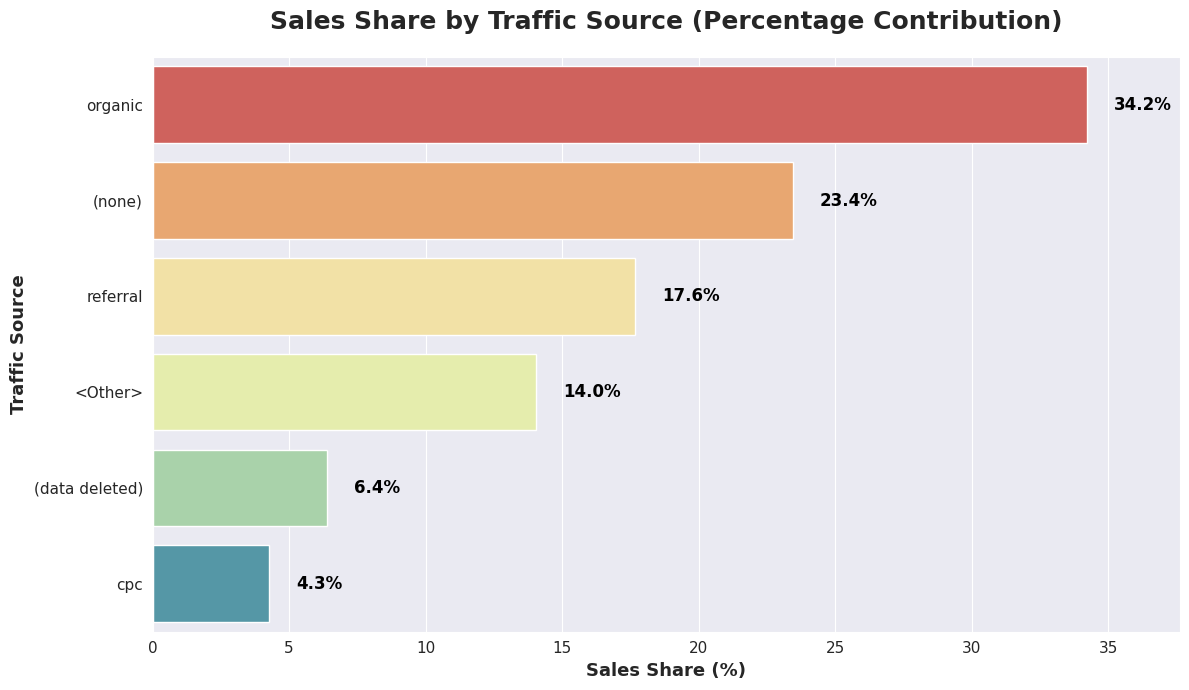

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate global total sales (needed for percentage calculation)
global_total_sales = converting_data['price'].sum()

# Group by the correct column name 'traffic_source'
traffic_source_sales = converting_data.groupby('traffic_source').agg(
    Total_Sales=('price', 'sum')
).reset_index().sort_values(by='Total_Sales', ascending=False)

# Calculate percentage of total sales
traffic_source_sales['Sales_Share (%)'] = (traffic_source_sales['Total_Sales'] / global_total_sales) * 100
print("\n--- SALES SHARE BY TRAFFIC SOURCE ---")
traffic_source_sales_formatted = traffic_source_sales.copy()
traffic_source_sales_formatted['Total_Sales'] = traffic_source_sales_formatted['Total_Sales'].apply(lambda x: f"${x:,.0f}")
traffic_source_sales_formatted['Sales_Share (%)'] = traffic_source_sales_formatted['Sales_Share (%)'].round(1).astype(str) + '%'
print(traffic_source_sales_formatted.to_string(index=False))


# Visualization

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='Sales_Share (%)',
    y='traffic_source',
    data=traffic_source_sales,
    palette='Spectral', # Use a dynamic palette
    hue='traffic_source',
    legend=False)
plt.title('Sales Share by Traffic Source (Percentage Contribution)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Sales Share (%)', fontsize=13, fontweight='bold')
plt.ylabel('Traffic Source', fontsize=13, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
for bar in ax.patches:
    x_val = bar.get_width()
    y_val = bar.get_y() + bar.get_height() / 2
    percentage = f"{x_val:.1f}%"
    plt.text(x_val + 1.0,
             y_val,
             percentage,
             color='black',
             ha="left",
             va="center",
             fontsize=12,
             fontweight='bold')
plt.xlim(0, traffic_source_sales['Sales_Share (%)'].max() * 1.1)

plt.tight_layout()
plt.show()

## Percentage of registered users who confirmed their email address.

*  **Solid Performance**: The **71.70%** email verification rate is considered a solid result in e-commerce. It means that nearly three-quarters of registered users successfully completed the email confirmation process (clicking the activation link).

* **User Quality and Motivation**: A high rate confirms that the majority of registrations are genuine users (not bots or fake addresses) and that they are sufficiently motivated to finalize the account activation process.

*  There is a remaining loss of **28.30%** (approximately 7,909 accounts) that initiated registration but did not finalize it.
    * **Friction in UX/UI**: An error in the sending or receiving process of the verification email (e.g., email landing in the spam folder, slow delivery).
    *  **User Burnout**: The user lost interest between the moment of registration and checking their inbox.

In [ ]:
# Filtering: Select only registered users (where account_id is not 'GUEST')
registered_users_df = df_clean[df_clean['account_id'] != 'GUEST'].copy()

# Counting the total number of unique registered accounts
total_registered_accounts = registered_users_df['account_id'].nunique()

# Counting the number of unique accounts with confirmed email (is_email_verified == True)
verified_accounts = registered_users_df[registered_users_df['is_email_verified'] == True]['account_id'].nunique()

# Calculating the verification rate (as a percentage)
if total_registered_accounts > 0:
    verification_rate = (verified_accounts / total_registered_accounts) * 100
else:
    verification_rate = 0.0

# 5. Displaying the results in a formatted output
print("\n--- EMAIL VERIFICATION RATE ANALYSIS ---")
print(f"Total Unique Registered Accounts: {total_registered_accounts:,}")
print(f"Total Unique Verified Accounts: {verified_accounts:,}")
print(f"Email Verification Rate: {verification_rate:.2f}%")


--- EMAIL VERIFICATION RATE ANALYSIS ---
Total Unique Registered Accounts: 27,945
Total Unique Verified Accounts: 20,036
Email Verification Rate: 71.70%


## Percentage of registered users who unsubscribed from the newsletter.

**Healthy Subscriber Base**: The unsubscription rate of **16.94%** means that **83.06%** of registered users **remain subscribed**. This is a very good result compared to e-commerce benchmarks, suggesting the company maintains high content quality and / or an appropriate sending frequency.

In [ ]:
# Filtering: Select only registered users (account_id is not 'GUEST')
registered_users_df = df_clean[df_clean['account_id'] != 'GUEST'].copy()

# Count total unique registered accounts
total_registered_accounts = registered_users_df['account_id'].nunique()

# Count unique registered accounts that have UNSUBSCRIBED
unsubscribed_accounts = registered_users_df[registered_users_df['is_subscribed'] == False]['account_id'].nunique()

# Calculating the unsubscription rate (as a percentage)
if total_registered_accounts > 0:
    unsubscription_rate = (unsubscribed_accounts / total_registered_accounts) * 100
else:
    unsubscription_rate = 0.0

# Displaying the results
print("\n--- NEWSLETTER UNSUBSCRIPTION RATE ANALYSIS ---")
print(f"Total Unique Registered Accounts: {total_registered_accounts:,}")
print(f"Total Unique Unsubscribed Accounts: {unsubscribed_accounts:,}")
print(f"Unsubscription Rate: {unsubscription_rate:.2f}%")


--- NEWSLETTER UNSUBSCRIPTION RATE ANALYSIS ---
Total Unique Registered Accounts: 27,945
Total Unique Unsubscribed Accounts: 4,735
Unsubscription Rate: 16.94%


## The purchasing behavior of unsubscribers compared to that of current subscribers.

This finding is counterintuitive. It suggests that customers with the highest transactional value are the ones most likely to abandon the email communication channel.

*  **Post-Large Purchase Churn**: These users may have unsubscribed after making a large, one-time purchase (e.g., furnishing an entire room), deciding they no longer need regular updates.

*  **High Value, Low Channel Loyalty**: These users are valuable in terms of AOV, but they do not value the email communication itself. Their brand loyalty is high in the spending context but low in the newsletter engagement context.

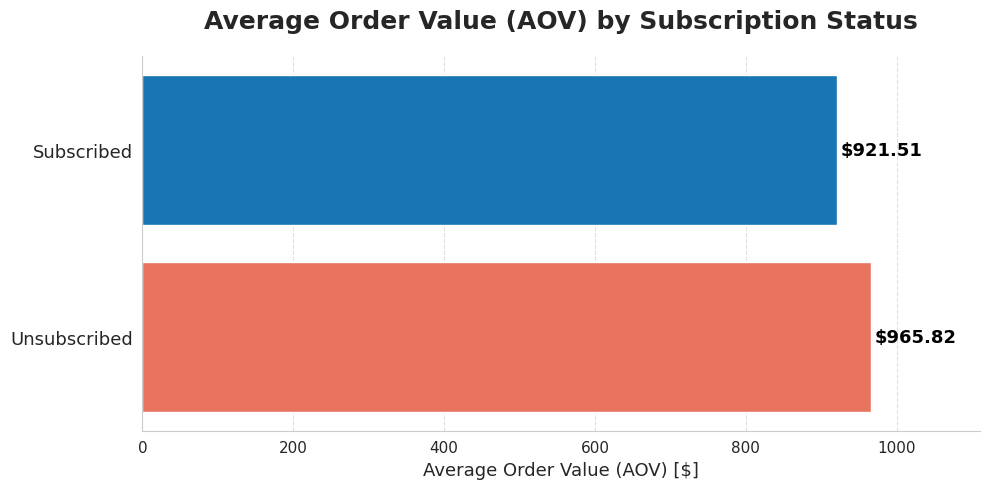

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sales_data = df_clean[df_clean['price'] > 0].copy()

# Registered users only, grouped by subscription status
registered_sales_data = sales_data[sales_data['account_id'] != 'GUEST'].copy()

# Calculate Average Order Value (AOV) by Subscription Status
aov_by_subscription = registered_sales_data.groupby('is_subscribed').agg(
    Total_Sales=('price', 'sum'),
    Total_Orders=('session_id', 'nunique')).reset_index()
aov_by_subscription['AOV'] = aov_by_subscription['Total_Sales'] / aov_by_subscription['Total_Orders']

# Format the results for display and visualization
aov_summary = aov_by_subscription.copy()
# Rename the column for plotting clarity
aov_summary['Status'] = aov_summary['is_subscribed'].replace({
    True: 'Subscribed',
    False: 'Unsubscribed'})

# Sort by AOV (highest at the top for better visualization flow)
aov_summary = aov_summary.sort_values(by='AOV', ascending=True)


#VISUALIZATION

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
colors = ['#007ACC' if status == 'Subscribed' else '#FF6347' for status in aov_summary['Status']]
ax = sns.barplot(
    x='AOV',
    y='Status',
    data=aov_summary,
    palette=colors,
    hue='Status',
    legend=False)
plt.title('Average Order Value (AOV) by Subscription Status', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Average Order Value (AOV) [$]', fontsize=13)
plt.ylabel(None) # Remove y-axis label for cleaner look
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
for bar in ax.patches:
    x_val = bar.get_width()
    y_val = bar.get_y() + bar.get_height() / 2
    label = f"${x_val:,.2f}"
    plt.text(x_val + 5,
             y_val,
             label,
             color='black',
             ha="left",
             va="center",
             fontsize=13,
             fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.xaxis.set_ticks_position('none')
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, aov_summary['AOV'].max() * 1.15)

plt.tight_layout()
plt.savefig('aov_by_subscription_status_combined.png')

## Countries with the most registered users.

The **Top 5 countries** with the highest number of registered users collectively account for the **largest percentage** of the entire account base.

*  The fact that the Top 5 markets generate such a large proportion of all registrations confirms that the company has achieved **significant penetration** in these specific regions.

*  Any activities aimed at **increasing reach** should continue to focus on these countries to **maximize Return on Investment (ROI)**.



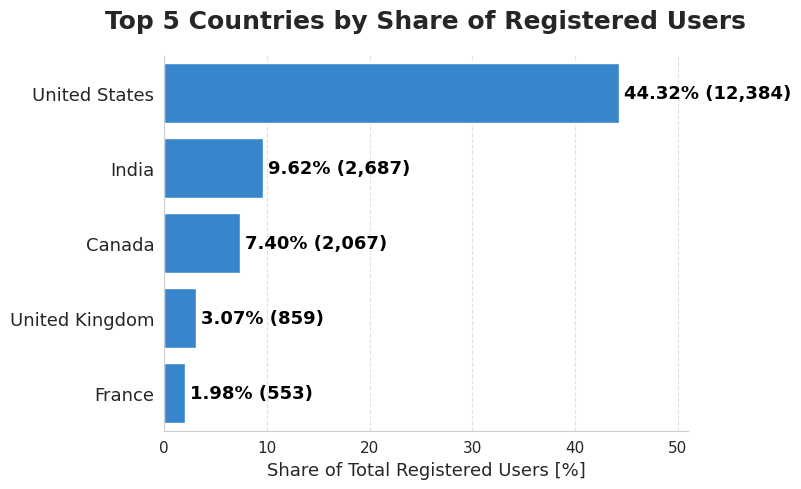

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DATA PREPARATION
registered_users_df = df_clean[df_clean['account_id'] != 'GUEST'].copy()
user_country_map = registered_users_df.groupby('account_id')['country'].first().reset_index()
country_user_count = user_country_map.groupby('country').agg(
    registered_user_count=('account_id', 'count')
).reset_index()
top_5_countries = country_user_count.sort_values(
    by='registered_user_count', ascending=False
).head(5)
total_registered_users = user_country_map['account_id'].nunique()

# Calculate the share for top 5
top_5_countries['share'] = (top_5_countries['registered_user_count'] / total_registered_users) * 100

# Prepare final DataFrame: Sort descending so the highest count is at the TOP of the horizontal chart
plot_data = top_5_countries.sort_values(by='registered_user_count', ascending=False).copy()


# VISUALIZATION:

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
AX_COLOR = '#1E88E5'
ax = sns.barplot(
    x='share',
    y='country',
    data=plot_data,
    color=AX_COLOR, # Zmieniony parametr z 'palette' na 'color'
    legend=False,
    order=plot_data['country'])
plt.title('Top 5 Countries by Share of Registered Users', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Share of Total Registered Users [%]', fontsize=13)
plt.ylabel(None)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
for bar in ax.patches:
    share_val = bar.get_width()
    y_position = bar.get_y() + bar.get_height() / 2
    country_index = int(round(y_position / 1))
    country_name = plot_data['country'].iloc[country_index]
    count_val = plot_data[plot_data['country'] == country_name]['registered_user_count'].iloc[0]
    label = f"{share_val:.2f}% ({count_val:,})"
    plt.text(share_val + 0.5,
             y_position,
             label,
             color='black',
             ha="left",
             va="center",
             fontsize=13,
             fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, plot_data['share'].max() * 1.15)

plt.tight_layout()
plt.savefig('top_5_countries_user_share_horizontal_final_blue_clean.png')


## AOV per Top 5 Countries

*  **French users** are the **most willing to spend large amounts** on a single order, indicating a strong premium customer segment.

*  The **United States** dominates in volume (1,208 users) and maintains a robust AOV ($950.29), acting as the primary revenue base.

*  The **United Kingdom** presents an opportunity for **immediate intervention** to raise the Average Order Value (AOV), as the large customer base is **currently underperforming** in terms of transactional value


--- AVERAGE ORDER VALUE (AOV) FOR TOP 5 COUNTRIES ---
       Country  Users Count     AOV
        France           57 1048.22
        Canada          208  952.31
 United States         1208  950.29
         India          247  927.62
United Kingdom           89  911.87


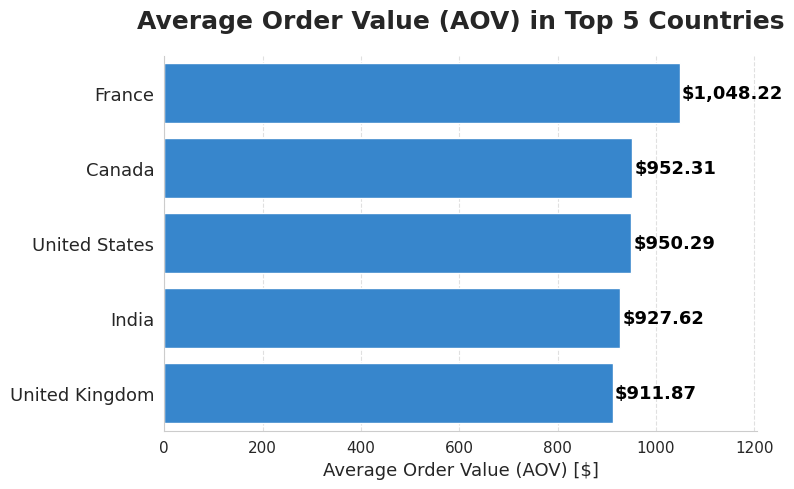

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.TOP 5 COUNTRIES BY REGISTERED USER COUNT
registered_users_df = df_clean[df_clean['account_id'] != 'GUEST'].copy()
user_country_map = registered_users_df.groupby('account_id')['country'].first().reset_index()

country_user_count = user_country_map.groupby('country').agg(
    registered_user_count=('account_id', 'count')
).reset_index()

top_5_countries_list = country_user_count.sort_values(
    by='registered_user_count', ascending=False
).head(5)['country'].tolist()

# CALCULATE AOV FOR SALES WITHIN THESE TOP 5 COUNTRIES
sales_data = df_clean[
    (df_clean['price'] > 0) &
    (df_clean['country'].isin(top_5_countries_list))].copy()
aov_by_country = sales_data.groupby('country').agg(
    Total_Sales=('price', 'sum'),
    Total_Orders=('session_id', 'nunique'),
).reset_index()
aov_by_country['AOV'] = aov_by_country['Total_Sales'] / aov_by_country['Total_Orders']

# Prepare final DataFrame: Sort descending so the highest AOV is at the TOP of the horizontal chart
plot_data = aov_by_country[['country', 'AOV']].sort_values(by='AOV', ascending=False).copy()


# VISUALIZATION

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
AX_COLOR = '#1E88E5'
ax = sns.barplot(
    x='AOV',
    y='country',
    data=plot_data,
    color=AX_COLOR,
    legend=False,
    order=plot_data['country'])
plt.title('Average Order Value (AOV) in Top 5 Countries', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Average Order Value (AOV) [$]', fontsize=13)
plt.ylabel(None)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
for bar in ax.patches:
    aov_val = bar.get_width()
    plt.text(aov_val + 5,
             bar.get_y() + bar.get_height() / 2,
             f"${aov_val:,.2f}",
             color='black',
             ha="left",
             va="center",
             fontsize=13,
             fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, plot_data['AOV'].max() * 1.15)
plt.tight_layout()
plt.savefig('aov_by_top_5_countries.png')


# table containing the number of accounts created
import numpy as np

registered_users_df = df_clean[df_clean['account_id'] != 'GUEST'].copy()
user_country_map = registered_users_df.groupby('account_id')['country'].first().reset_index()
country_user_count = user_country_map.groupby('country').agg(
    registered_user_count=('account_id', 'count')).reset_index()

top_5_countries_list = country_user_count.sort_values(
    by='registered_user_count', ascending=False
).head(5)['country'].tolist()

sales_data = df_clean[
    (df_clean['price'] > 0) &
    (df_clean['country'].isin(top_5_countries_list))].copy()
aov_by_country = sales_data.groupby('country').agg(
    Total_Sales=('price', 'sum'),
    Total_Orders=('session_id', 'nunique'),
    Registered_Users=('account_id', 'nunique')).reset_index()
aov_by_country['AOV'] = aov_by_country['Total_Sales'] / aov_by_country['Total_Orders']

final_table = aov_by_country[['country', 'Registered_Users', 'AOV']].copy()
final_table = final_table.sort_values(by='AOV', ascending=False)
final_table = final_table.rename(columns={'country': 'Country', 'Registered_Users': 'Users Count'})
print("\n--- AVERAGE ORDER VALUE (AOV) FOR TOP 5 COUNTRIES ---")
print(final_table.to_string(index=False, float_format='{:.2f}'.format))

# SALES DYNAMICS ANALYSIS

## Sales dynamics and seasonality

*  **Volume Peak (Tuesday – Wednesday)**: The highest revenue and order volume are concentrated mid-week. Wednesday leads in total sales, while Tuesday leads in order count. This period is ideal for major acquisition campaigns and announcements.

*  **Weekend Dip (Saturday – Sunday)**: Sales drop sharply on weekends. Sunday shows the lowest results in both total sales and, critically, the lowest Average Order Value (AOV) ($896.59). The volume dip is significant, representing approximately a 36% drop compared to the mid-week peak.

*  **Highest AOV Value**: Despite lower total sales, Thursday and Friday generate the highest AOV (984.43 USD and 986.28 USD, respectively). This suggests customers transacting at the end of the working week are more inclined to place higher-value items in their carts.

*  **Optimization Market (Sunday)**: Sunday is the weakest day for value. High session counts (relative to Saturday) but low AOV and sales suggest customers are browsing but making smaller or more impulsive purchases.


--- SALES METRICS BY DAY OF THE WEEK (Seasonality Analysis) ---
Day of Week  Total Sales [$]  Total Orders  Avg Transaction Value [$]
     Monday       4636290.40          4962                     934.36
    Tuesday       5457515.90          5763                     946.99
  Wednesday       5466542.90          5614                     973.73
   Thursday       4936935.60          5015                     984.43
     Friday       4523067.20          4586                     986.28
   Saturday       3477990.90          3724                     933.94
     Sunday       3473388.20          3874                     896.59


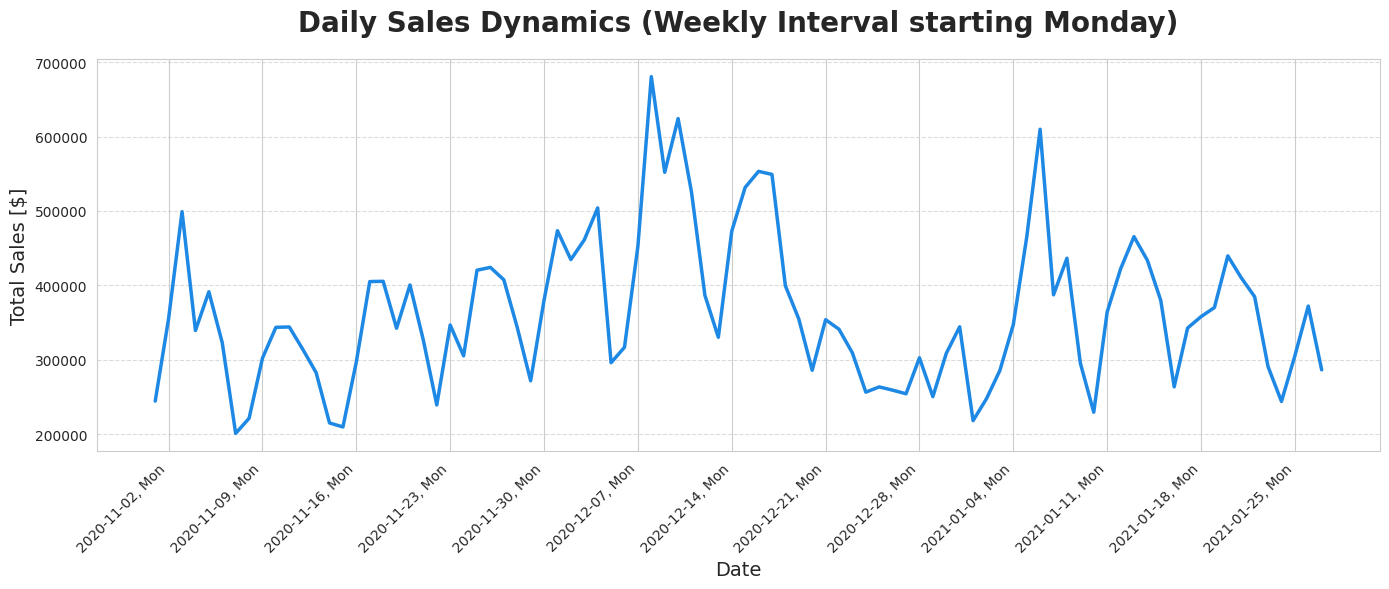

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# DATA PREPARATION
sales_data = df_clean[df_clean['price'] > 0].copy()

# Extract day of the week number (0=Monday, 6=Sunday)
sales_data['day_of_week_num'] = sales_data['session_date'].dt.dayofweek
# Extract day of the week name for readability
sales_data['day_of_week_name'] = sales_data['session_date'].dt.day_name()

# CALCULATE SALES AND ORDERS PER DAY OF THE WEEK
sales_by_day = sales_data.groupby(['day_of_week_num', 'day_of_week_name']).agg(
    Total_Sales=('price', 'sum'),
    Total_Orders=('session_id', 'nunique'),
    Average_Daily_Sales=('price', 'mean')).reset_index()

# SORTING AND TABLE FORMATTING
sales_by_day = sales_by_day.sort_values(by='day_of_week_num')
sales_by_day = sales_by_day.rename(columns={
    'day_of_week_name': 'Day of Week',
    'Total_Sales': 'Total Sales [$]',
    'Total_Orders': 'Total Orders',
    'Average_Daily_Sales': 'Avg Transaction Value [$]'})
final_table = sales_by_day[['Day of Week', 'Total Sales [$]', 'Total Orders', 'Avg Transaction Value [$]']].copy()

# DISPLAY THE TABLE
print("\n--- SALES METRICS BY DAY OF THE WEEK (Seasonality Analysis) ---")
print(final_table.to_string(index=False, float_format='{:.2f}'.format))


# CALCULATE TOTAL SALES PER DATE
sales_by_date = df_clean[df_clean['price'] > 0].groupby('session_date').agg(
    Total_Sales=('price', 'sum')).reset_index()
sales_by_date = sales_by_date.sort_values(by='session_date')


# VISUALIZATION

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))
ax = sns.lineplot(
    x='session_date',
    y='Total_Sales',
    data=sales_by_date,
    color='#1E88E5',
    linewidth=2.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
# ZMIANA: Dodano formatowanie %Y-%%m-%%d (Rok-Miesiąc-Dzień)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d, %a'))
plt.title('Daily Sales Dynamics (Weekly Interval starting Monday)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales [$]', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('daily_sales_dynamics_monday_start.png')

## Analysis of sales dynamics in America, Asia and Europe.

*  Sales peaks are **synchronized across all three continents**. The events driving sales growth (e.g., company promotions, global holidays, sales season) work equally well in every region, and their calendar is aligned.

*  The **Americas market** is a key revenue pillar. Its stability must be protected and maintained.

*  Since the peaks are synchronous, **global promotions are effective**. This model should be sustained, but in the future, implement different discount or promotion levels depending on the continent to increase engagement in Asia and Europe.

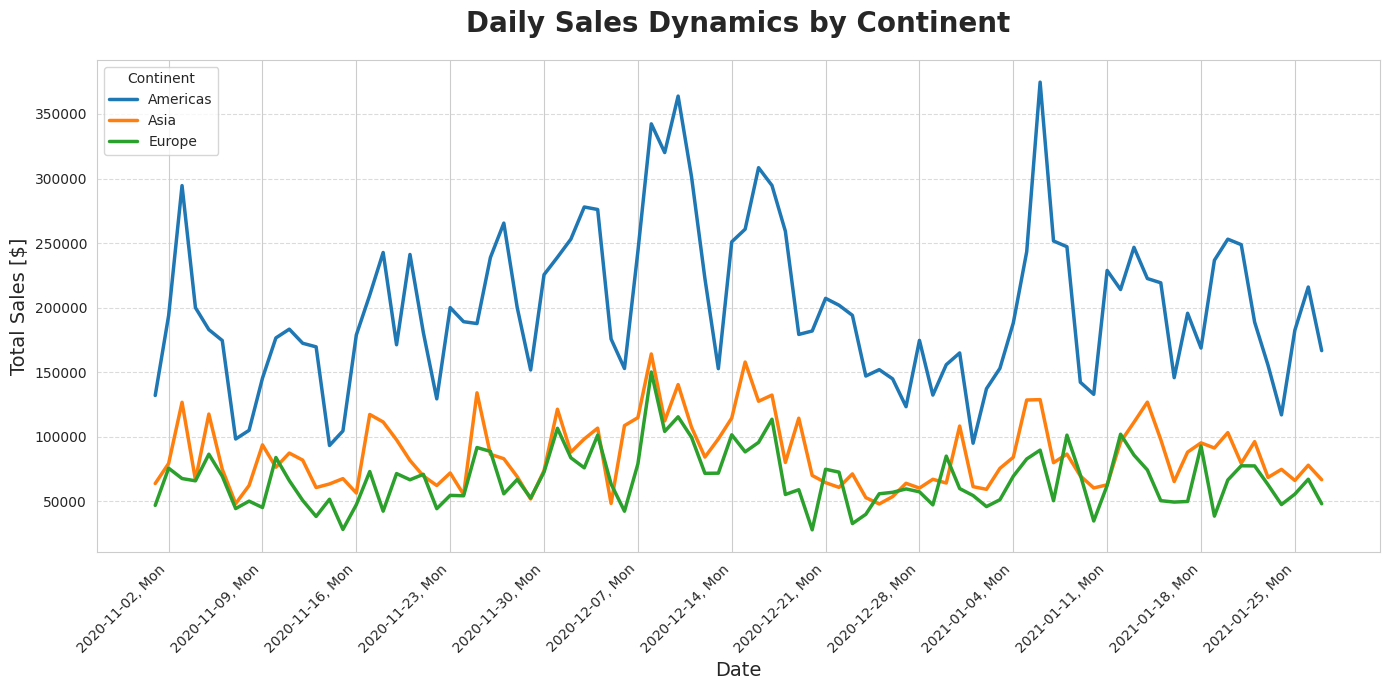

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# DATA PREPARATION
# Filter for sales transactions only (price > 0)
sales_data = df_clean[df_clean['price'] > 0].copy()

# Filter only for the main continents of interest (Americas, Asia, Europe)
target_continents = ['Americas', 'Asia', 'Europe']
sales_data_filtered = sales_data[sales_data['continent'].isin(target_continents)].copy()

# Group data by date and continent to calculate daily sales for each region
sales_by_continent_date = sales_data_filtered.groupby(['session_date', 'continent']).agg(
    Total_Sales=('price', 'sum')).reset_index()

# Sort data by date
sales_by_continent_date = sales_by_continent_date.sort_values(by='session_date')


# VISUALIZATION

sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    x='session_date',
    y='Total_Sales',
    hue='continent',
    data=sales_by_continent_date,
    linewidth=2.5)
plt.title('Daily Sales Dynamics by Continent', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales [$]', fontsize=14)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
# ZMIANA: Dodano formatowanie daty z uwzględnieniem roku (%Y-%m-%d)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d, %a'))
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Continent', loc='upper left')
plt.tight_layout()
plt.savefig('daily_sales_dynamics_by_continent.png')

## Analysis of sales dynamics by traffic channels.

*  **Sales Leader: Organic traffic** (e.g., search engine results) is the absolute foundation of your sales, accounting for nearly half (44.07%) of the total revenue.

*  **Key** (none) **Category**: The (none) channel (often direct traffic or unclassified) is the second-largest revenue source. It also maintains a high **Average Order Value (AOV)**, suggesting that customers arriving directly are high-value buyers.

*  Sales during weekdays (excluding the major peaks) are consistently higher than on weekends (Saturday and Sunday). For instance, **Organic** sales often drop below **Referral** or **(none)** sales on weekends.

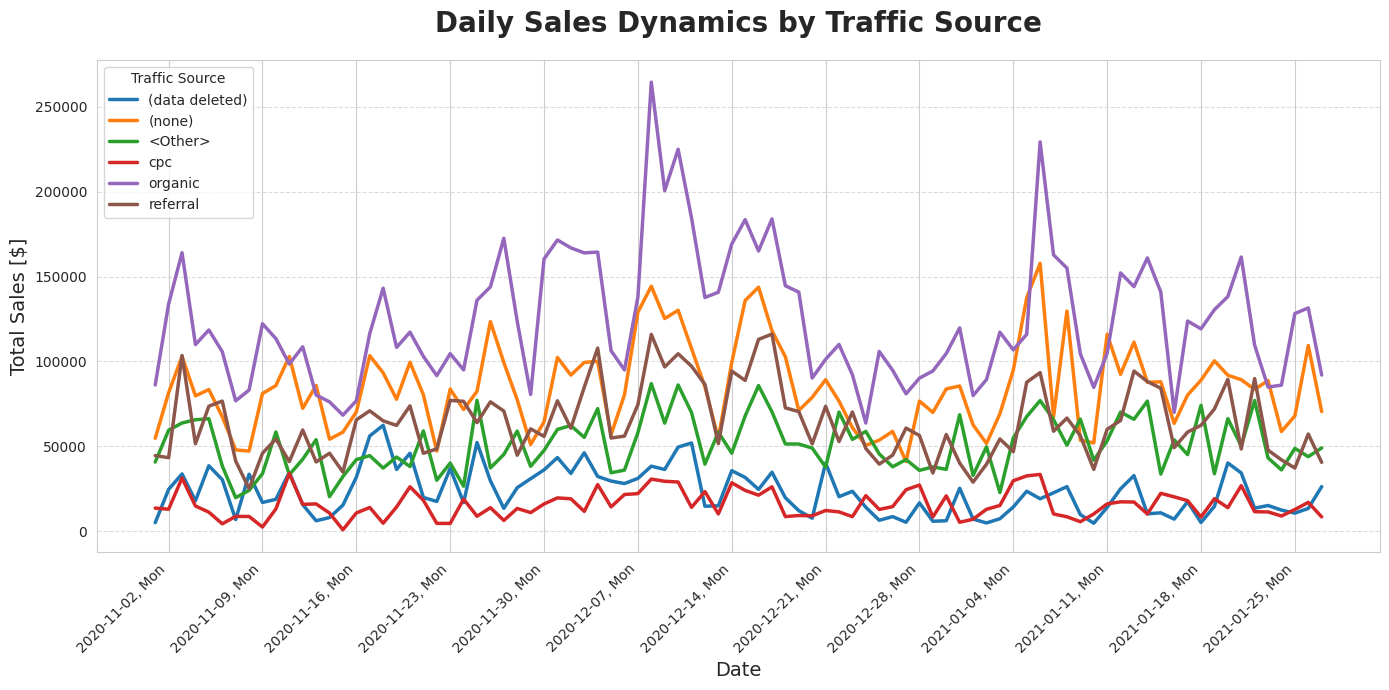

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# DATA PREPARATION
sales_data = df_clean[df_clean['price'] > 0].copy()
sales_by_traffic_date = sales_data.groupby(['session_date', 'traffic_source']).agg(
    Total_Sales=('price', 'sum')).reset_index()

# Sort data by date
sales_by_traffic_date = sales_by_traffic_date.sort_values(by='session_date')


# VISUALIZATION

sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    x='session_date',
    y='Total_Sales',
    hue='traffic_source',
    data=sales_by_traffic_date,
    linewidth=2.5)
plt.title('Daily Sales Dynamics by Traffic Source', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales [$]', fontsize=14)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
# ZMIANA: Zaktualizowano formatowanie osi X, aby zawierało rok (%Y-%m-%d)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d, %a'))
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Traffic Source', loc='upper left')

plt.tight_layout()
plt.savefig('daily_sales_dynamics_by_traffic.png')


## Analysis of sales dynamics by device type.

*  **Desktop:** This channel serves as the primary revenue driver and the main conversion point during promotional periods.

*  **Mobile:** Provides a crucial, steady stream of revenue but rarely matches Desktop performance.

* **Tablet:** The contribution of tablets is statistically insignificant and does not influence the overall trend.

*  **Main Takeaway:** Mobile devices provide a very stable sales foundation that appears less responsive to major promotions. Mobile users may face challenges in finalizing large transactions, or the mobile checkout process may not be sufficiently optimized.

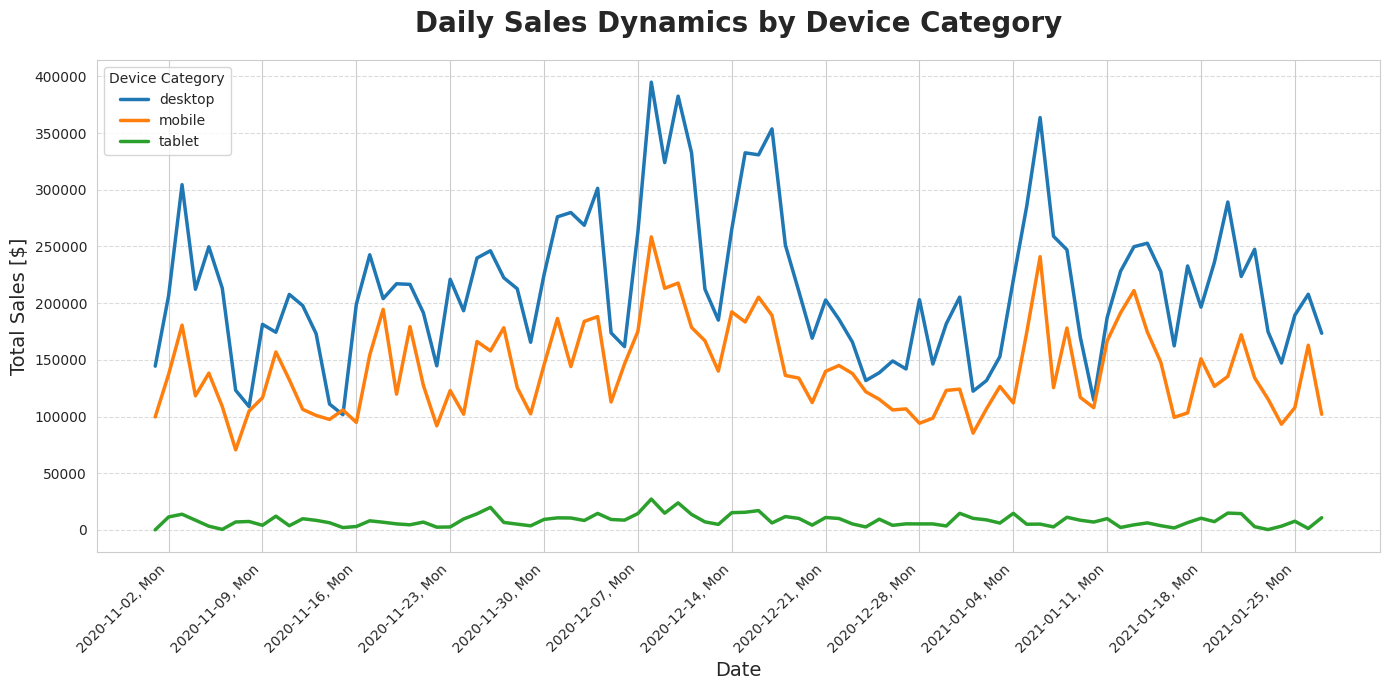

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# DATA PREPARATION
# Filter for transactions (price > 0)
sales_data = df_clean[df_clean['price'] > 0].copy()

# Group by date and DEVICE
sales_by_device_date = sales_data.groupby(['session_date', 'device']).agg(
    Total_Sales=('price', 'sum')).reset_index()

# Sort data by date
sales_by_device_date = sales_by_device_date.sort_values(by='session_date')


# VISUALIZATION

sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    x='session_date',
    y='Total_Sales',
    hue='device',
    data=sales_by_device_date,
    linewidth=2.5)
plt.title('Daily Sales Dynamics by Device Category', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales [$]', fontsize=14)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d, %a'))
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Device Category', loc='upper left')
plt.tight_layout()

plt.savefig('daily_sales_dynamics_by_device_final.png')

# SUMMARY OF KEY SALES AND TRAFFIC DIMENSIONS (Key Pivot Tables).

## Number of Sessions by Traffic Source and Device

*  **Organic (Free Search Traffic) is the Volume Leader:** This channel generates the highest number of sessions, serving as the foundation of the user base. This is a healthy situation as this traffic is free and scalable through SEO optimization.

*  **Referral (Third-Party Referrals) is a Strong Partner:** As the second-largest source of sessions, this indicates the store has a strong presence on external websites (e.g., industry blogs, partner sites) that drive substantial traffic volume

*  **CPC (Paid Campaigns):** This channel provides significant support but, in terms of volume, it is substantially smaller than the free channels.

*  **Conversion Implication:** Given the prior knowledge that Desktop converts significantly better (from the daily sales analysis), the lower volume of mobile sessions—combined with their historically lower conversion rate—confirms a **critical problem**: Mobile potential is not being fully realized. Mobile users are present, but their path to purchase is likely being hindered by poor User Experience (UX).

In [ ]:
import pandas as pd
import numpy as np

# List of unwanted traffic sources to exclude
AMBIGUOUS_TRAFFIC = ['(none)', '<Other>', 'nan', '', '(data deleted)']
AMBIGUOUS_DEVICE = ['(not set)', 'nan', '']

# Copying data and filtering out rows with ambiguous traffic sources and device types
sessions_pivot = df_clean.copy()
sessions_pivot_filtered = sessions_pivot[
    (~sessions_pivot['traffic_source'].isin(AMBIGUOUS_TRAFFIC)) &
    (~sessions_pivot['device'].isin(AMBIGUOUS_DEVICE))].copy()

# pivot table
traffic_device_sessions = sessions_pivot_filtered.pivot_table(
    index='traffic_source',
    columns='device',
    values='session_id',
    aggfunc='nunique',
    fill_value=0)

# Adding row sum (Total Sessions per Traffic Source)
traffic_device_sessions['Total Sessions'] = traffic_device_sessions.sum(axis=1)

# Sorting and formatting
traffic_device_sessions = traffic_device_sessions.sort_values(by='Total Sessions', ascending=False)
traffic_device_sessions.columns.name = 'Device Type'
traffic_device_sessions.index.name = 'Traffic Source'
traffic_device_sessions = traffic_device_sessions.map('{:,.0f}'.format)

print("## 1. SESSION COUNT BY TRAFFIC SOURCE AND DEVICE")
print(traffic_device_sessions)

## 1. SESSION COUNT BY TRAFFIC SOURCE AND DEVICE
Device Type    desktop  mobile tablet Total Sessions
Traffic Source                                      
organic         69,431  46,934  2,659        119,024
referral        35,891  24,183  1,363         61,437
cpc              8,972   5,921    357         15,250


## Total Sales (Top 10 Products x Top 5 Countries)

*  **USA is the Absolute Sales Center**: In every single Top 10 product category, the United States generates the overwhelming majority of sales

*  **Leaders: Large, High-Value Furniture:** The top three selling categories are 'Sofas & armchairs', 'Chairs', and 'Beds'. This suggests the store specializes in selling large, higher-priced items that form the core of the purchasing cart.

*  **India's Interesting Contribution:** India shows a surprisingly high sales volume in key categories ('Sofas & armchairs', 'Chairs'), often matching or slightly exceeding Canada's performance.


In [ ]:
import pandas as pd
import numpy as np

# List of ambiguous/unwanted traffic sources to exclude
AMBIGUOUS_TRAFFIC = ['(none)', '<Other>', 'nan', '', '(data deleted)']
sales_data = df_clean[df_clean['price'] > 0].copy()
sales_data_filtered = sales_data[
    (~sales_data['traffic_source'].isin(AMBIGUOUS_TRAFFIC))].copy()

# Identifying the top 10 product categories and top 5 countries by sales volume
top_10_categories = sales_data_filtered['product_category'].value_counts().nlargest(10).index.tolist()
top_5_countries = sales_data_filtered['country'].value_counts().nlargest(5).index.tolist()

# Filtering data for the Top 10x5 matrix
sales_product_country_filtered = sales_data_filtered[
    (sales_data_filtered['product_category'].isin(top_10_categories)) &
    (sales_data_filtered['country'].isin(top_5_countries))].copy()

# pivot table: Sum of Sales
product_country_sales = sales_product_country_filtered.pivot_table(
    index='product_category',
    columns='country',
    values='price',
    aggfunc='sum',
    fill_value=0)

# Adding row sum (Total Sales per Product Category)
product_country_sales['Total Sales ($)'] = product_country_sales.sum(axis=1)

# Sorting and formatting
product_country_sales = product_country_sales.sort_values(by='Total Sales ($)', ascending=False)
product_country_sales.columns.name = 'Country'
product_country_sales.index.name = 'Top 10 Product Category'
# Applying currency format to the body of the table
product_country_sales = product_country_sales.apply(lambda x: x.map('${:,.2f}'.format))
product_country_sales['Total Sales ($)'] = (
    product_country_sales['Total Sales ($)']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
    .map('${:,.2f}'.format))


print("TOTAL SALES (TOP 10 PRODUCTS X TOP 5 COUNTRIES)")
print(product_country_sales)

TOTAL SALES (TOP 10 PRODUCTS X TOP 5 COUNTRIES)
Country                                Canada       France        India  \
Top 10 Product Category                                                   
Sofas & armchairs                 $364,461.00  $107,464.00  $406,847.00   
Chairs                            $235,071.40   $73,343.00  $310,534.80   
Beds                              $196,086.50   $56,592.00  $213,267.50   
Bookcases & shelving units        $141,604.70   $50,400.20  $195,961.60   
Cabinets & cupboards               $98,611.00   $24,762.00   $99,528.50   
Outdoor furniture                 $113,780.20   $30,160.80   $80,022.80   
Tables & desks                     $69,761.50   $27,558.00   $84,922.00   
Chests of drawers & drawer units   $42,502.00   $11,765.00   $34,489.00   
Bar furniture                      $28,289.00   $10,325.00   $32,549.00   
Children's furniture               $17,781.00    $7,332.00   $21,996.00   

Country                          United Kingdom  Un

## Conversion Rate (CR) by Traffic Source and Device

*  Despite minor fluctuations, the overall Conversion Rate for all examined segments remains at a **high and stable level**, consistently orbiting 9–10%.

*  Based strictly on the CR indicators, the **existing purchase path is highly optimized**. The company is not losing customers due to technical issues within the checkout process. The efficiency of Desktop, Mobile, and Tablet is sufficiently close that none of these segments require urgent intervention in terms of conversion rate optimization.

In [ ]:
import pandas as pd
import numpy as np

# Define the ambiguous values to be excluded for clean traffic analysis
AMBIGUOUS_TRAFFIC = ['(none)', '<Other>', 'nan', '', '(data deleted)']
AMBIGUOUS_DEVICE = ['(not set)', 'nan', '']

# Filter data for clean traffic/device segments
df_filtered = df_clean[
    (~df_clean['traffic_source'].isin(AMBIGUOUS_TRAFFIC)) &
    (~df_clean['device'].isin(AMBIGUOUS_DEVICE))].copy()

# Calculate Total Sessions (Denominator for CR)
total_sessions = df_filtered.groupby(['traffic_source', 'device'])['session_id'].nunique().reset_index(name='Total_Sessions')

# Calculate Total Transactions (Numerator for CR)
transactions = df_filtered[df_filtered['price'] > 0]
total_transactions = transactions.groupby(['traffic_source', 'device'])['session_id'].nunique().reset_index(name='Total_Transactions')

# Merge the two DataFrames
df_conversion = pd.merge(total_sessions, total_transactions,
                         on=['traffic_source', 'device'],
                         how='left').fillna(0)
df_conversion['Conversion_Rate (%)'] = (df_conversion['Total_Transactions'] / df_conversion['Total_Sessions']) * 100

# Pivot the table for final display
cr_pivot = df_conversion.pivot_table(
    index='traffic_source',
    columns='device',
    values='Conversion_Rate (%)',
    fill_value=0)

# Add an overall CR for the traffic source
cr_pivot['Overall CR (%)'] = (
    df_conversion.groupby('traffic_source')['Total_Transactions'].sum() /
    df_conversion.groupby('traffic_source')['Total_Sessions'].sum()) * 100

# Sort and Format
cr_pivot = cr_pivot.sort_values(by='Overall CR (%)', ascending=False)
cr_pivot.columns.name = 'Device Type'
cr_pivot.index.name = 'Traffic Source'
cr_pivot = cr_pivot.map('{:.2f}%'.format)


print("CONVERSION RATE (%) BY TRAFFIC SOURCE AND DEVICE")
print(cr_pivot)

CONVERSION RATE (%) BY TRAFFIC SOURCE AND DEVICE
Device Type    desktop mobile  tablet Overall CR (%)
Traffic Source                                      
referral         9.72%  9.89%   8.73%          9.77%
organic          9.71%  9.48%   8.95%          9.60%
cpc              9.01%  9.42%  11.48%          9.23%


# STATISTICAL RELATIONSHIP ANALYSIS

## Statistical Analysis: Number of Sessions vs. Total Sales

*  **Pearson Correlation Coefficient (r)** of 0.7911 **is high and positive**.
This indicates a **strong, positive, and linear relationship** between the daily number of sessions and total sales. An increase in traffic (sessions) is directly and proportionally associated with an increase in revenue (sales). This is a characteristic, fundamental relationship in e-commerce.

*  **Correlation (p-value) is highly statistically significant**. The relationship is not due to random chance and is highly reliable.

*  **Traffic Drives Revenue:** Fluctuations in total sales are strongly driven by fluctuations in the number of sessions. On days when the store records higher traffic, higher sales can be anticipated with high certainty.

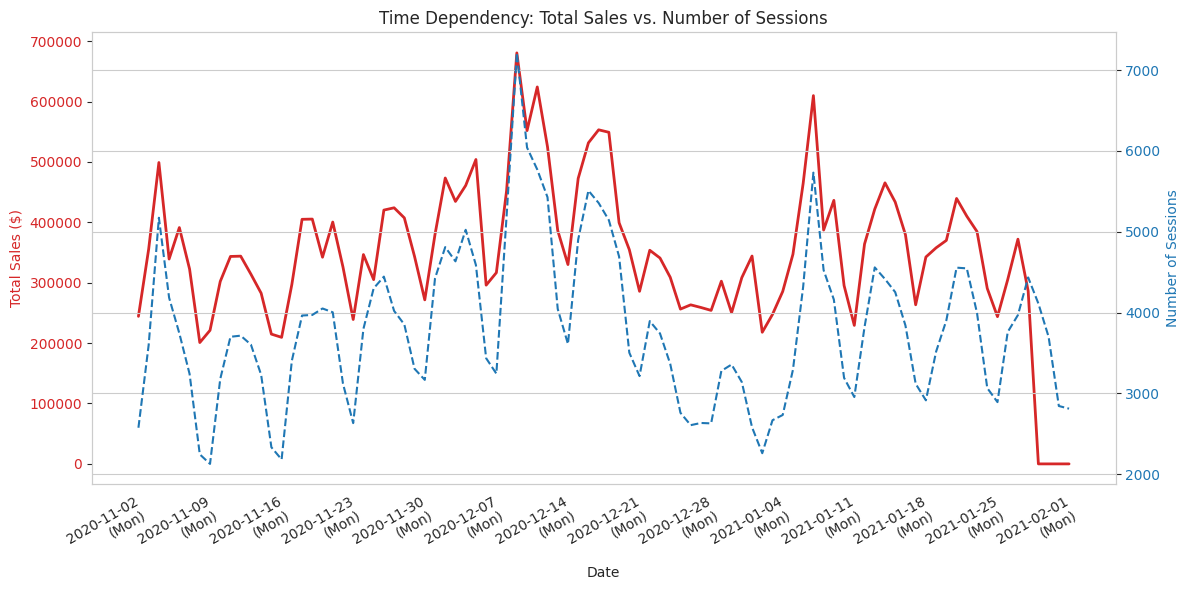


--- STATISTICAL ANALYSIS: SESSIONS VS. SALES ---

Number of days in the dataset: 92
Pearson Correlation Coefficient (r): 0.7911
P-value: 0.000000

--- DAILY SESSION AND SALES DATA ---

         Date  Total Sessions  Total Sales ($)
0  2020-11-01            2576         244292.5
1  2020-11-02            3599         355506.8
2  2020-11-03            5173         498979.6
3  2020-11-04            4184         339187.1
4  2020-11-05            3743         391276.6
..        ...             ...              ...
87 2021-01-27            4435         286340.7
88 2021-01-28            4112              0.0
89 2021-01-29            3700              0.0
90 2021-01-30            2845              0.0
91 2021-01-31            2812              0.0

[92 rows x 3 columns]


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Define the correct date column name
DATE_COLUMN = 'session_date'

# Data Aggregation: Sessions and Sales by Date
df_daily = df_clean.groupby(DATE_COLUMN).agg(
    Total_Sessions=('session_id', 'nunique'),
    Total_Sales=('price', 'sum')).reset_index()

# Calculate Pearson Correlation and Statistical Significance
if len(df_daily) >= 2:
    correlation_coefficient, p_value = pearsonr(df_daily['Total_Sessions'], df_daily['Total_Sales'])
else:
    correlation_coefficient, p_value = np.nan, np.nan


# Visualization

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n(%a)'))
fig.autofmt_xdate()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales ($)', color=color)
ax1.plot(df_daily[DATE_COLUMN], df_daily['Total_Sales'], color=color, label='Total Sales', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of Sessions', color=color)
ax2.plot(df_daily[DATE_COLUMN], df_daily['Total_Sessions'], color=color, label='Number of Sessions', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Time Dependency: Total Sales vs. Number of Sessions')
fig.tight_layout()
plt.show()

print("\n--- STATISTICAL ANALYSIS: SESSIONS VS. SALES ---\n")
print(f"Number of days in the dataset: {len(df_daily)}")
print(f"Pearson Correlation Coefficient (r): {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.6f}")

# Displaying the resulting table
df_daily.rename(columns={DATE_COLUMN: 'Date', 'Total_Sessions': 'Total Sessions', 'Total_Sales': 'Total Sales ($)'}, inplace=True)
print("\n--- DAILY SESSION AND SALES DATA ---\n")
print(df_daily)

## Analysis of Sales Dependencies Between Continents

*  **A very strong, positive correlation** was observed across all three continent pairs. The Pearson correlation coefficient (r) consistently remains at a high level, ranging from 0.7684 to 0.7920.

*  This result signifies that daily sales across these regions move in **deep synchronization**. An increase in revenue in one region is immediately mirrored by a proportional increase in the other regions, indicating that sales momentum is largely driven by global, cohesive factors.

*  All observed correlations are **highly statistically significant** (well below the standard threshold of alpha=0.05). We are confident that the strong link between the regions **is not random** but represents a reliable and persistent pattern in the data.

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
from itertools import combinations
import numpy as np

DATE_COLUMN = 'session_date'
print("STATISTICAL RELATIONSHIP ANALYSIS\n")

# Aggregate total sales by continent
continent_sales = df_clean.groupby('continent')['price'].sum().sort_values(ascending=False)

# Select the top 3 continents
top_3_continents = continent_sales.head(3).index.tolist()

print(f"TOP 3 CONTINENTS IDENTIFIED")
print(f"Selected Continents: {', '.join(top_3_continents)}")
print("-" * 50)


# Aggregate Daily Sales for the Selected Continents

df_top_3 = df_clean[df_clean['continent'].isin(top_3_continents)]
df_sales_by_continent = df_top_3.groupby([DATE_COLUMN, 'continent'])['price'].sum().unstack().fillna(0)
df_sales_by_continent.columns = [f'{c}_Sales' for c in df_sales_by_continent.columns]

print("DAILY SALES AGGREGATION (Top 5 Rows)")
print(df_sales_by_continent.head().to_string())
print("-" * 50)


# Calculate Inter-Continent Correlation (Pearson R and P-value) ---
correlation_results = {}
# Create pairs: (C1, C2), (C1, C3), (C2, C3)
continent_pairs = list(combinations(top_3_continents, 2))

print("CORRELATION MATRIX CALCULATION")

for c1_name, c2_name in continent_pairs:
    c1_col = f'{c1_name}_Sales'
    c2_col = f'{c2_name}_Sales'
    data_c1 = df_sales_by_continent[c1_col]
    data_c2 = df_sales_by_continent[c2_col]
    r, p = pearsonr(data_c1, data_c2)
    pair_label = f'{c1_name} vs {c2_name}'
    correlation_results[pair_label] = {'Pearson r': r, 'P-value': p}

    print(f"Relationship: {c1_name} vs {c2_name} | Pearson r: {r:.4f} | P-value: {p:.6f}")

print("-" * 50)

# Convert final results to a DataFrame for clean, tabular presentation
df_correlation_matrix = pd.DataFrame(correlation_results).T

print("\n--- FINAL STATISTICAL MATRIX (English) ---")
print(df_correlation_matrix.to_string(float_format='%.4f'))

STATISTICAL RELATIONSHIP ANALYSIS

TOP 3 CONTINENTS IDENTIFIED
Selected Continents: Americas, Asia, Europe
--------------------------------------------------
DAILY SALES AGGREGATION (Top 5 Rows)
              Americas_Sales  Asia_Sales  Europe_Sales
session_date                                          
2020-11-01          132002.5     63823.0       46908.0
2020-11-02          193861.0     79370.0       75710.8
2020-11-03          294529.8    126737.8       67692.0
2020-11-04          200009.5     66602.0       65915.0
2020-11-05          182988.2    117608.4       86540.0
--------------------------------------------------
CORRELATION MATRIX CALCULATION
Relationship: Americas vs Asia | Pearson r: 0.7920 | P-value: 0.000000
Relationship: Americas vs Europe | Pearson r: 0.7706 | P-value: 0.000000
Relationship: Asia vs Europe | Pearson r: 0.7684 | P-value: 0.000000
--------------------------------------------------

--- FINAL STATISTICAL MATRIX (English) ---
                    Pearson r 

## Sales correlation by traffic source

*  The vast majority of relationships (six out of ten) show a **strong or moderately strong correlation** (r > 0.60), with the highest values reaching r = 0.8209 (organic vs. none) and r = 0.8061 (organic vs. referral).

*  The strongest linkages are found among the three core channels: organic, (none) (often Direct traffic), and referral. This means that daily sales in these channels **move almost perfectly parallel**. When organic sales increase, it is almost certain that sales from (none) and referral channels will also increase.

*  For nine out of ten relationships, the P-value is 0.00, which is highly statistically significant. All observed relationships, even those of moderate strength, are **reliable and non-random**. Sales across all five major channels are linked in a way that can be generalized.

*  The strong correlation among the core channels (organic, (none), referral) suggests that **overall demand trends, global promotions, or general daily fluctuations in consumer interest** simultaneously impact all these major sources.

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
from itertools import combinations
import numpy as np

DATE_COLUMN = 'session_date'
TRAFFIC_SOURCE_COLUMN = 'traffic_source'

# Identify the Top 5 Traffic Sources by Total Sales ---

channel_sales = df_clean.groupby(TRAFFIC_SOURCE_COLUMN)['price'].sum().sort_values(ascending=False)
top_5_channels = channel_sales.head(5).index.tolist()

print(f"TOP 5 TRAFFIC SOURCES IDENTIFIED")
print(f"Selected Sources: {', '.join(top_5_channels)}")
print("-" * 50)


# Aggregate Daily Sales for the Selected Channels

df_top_5 = df_clean[df_clean[TRAFFIC_SOURCE_COLUMN].isin(top_5_channels)]
df_sales_by_channel = df_top_5.groupby([DATE_COLUMN, TRAFFIC_SOURCE_COLUMN])['price'].sum().unstack().fillna(0)
df_sales_by_channel.columns = [f'{c}_Sales' for c in df_sales_by_channel.columns]

print("DAILY SALES AGGREGATION BY SOURCE (Top 5 Rows)")
print(df_sales_by_channel.head().to_string())
print("-" * 50)


# Calculate Inter-Channel Correlation (Pearson R and P-value)

correlation_results = {}
channel_pairs = list(combinations(top_5_channels, 2))

print("CORRELATION MATRIX CALCULATION")

for c1_name, c2_name in channel_pairs:
    c1_col = f'{c1_name}_Sales'
    c2_col = f'{c2_name}_Sales'
    data_c1 = df_sales_by_channel[c1_col]
    data_c2 = df_sales_by_channel[c2_col]
    r, p = pearsonr(data_c1, data_c2)
    pair_label = f'{c1_name} vs {c2_name}'
    correlation_results[pair_label] = {'Pearson r': r, 'P-value': p}

    print(f"Relationship: {c1_name} vs {c2_name} | Pearson r: {r:.4f} | P-value: {p:.6f}")
print("-" * 50)

# Convert final results
df_correlation_matrix = pd.DataFrame(correlation_results).T

print("\n--- FINAL STATISTICAL MATRIX (English) ---")
print(df_correlation_matrix.to_string(float_format='%.4f'))

TOP 5 TRAFFIC SOURCES IDENTIFIED
Selected Sources: organic, (none), referral, <Other>, (data deleted)
--------------------------------------------------
DAILY SALES AGGREGATION BY SOURCE (Top 5 Rows)
              (data deleted)_Sales  (none)_Sales  <Other>_Sales  organic_Sales  referral_Sales
session_date                                                                                  
2020-11-01                  4920.0       54669.5        40657.0        86081.0         44450.0
2020-11-02                 24575.0       81561.5        59446.0       133845.8         43236.0
2020-11-03                 33649.4      102909.5        63688.4       164064.9        103464.4
2020-11-04                 17847.0       79683.6        65577.0       109893.1         51445.4
2020-11-05                 38461.4       83367.6        66219.0       118528.4         73580.2
--------------------------------------------------
CORRELATION MATRIX CALCULATION
Relationship: organic vs (none) | Pearson r: 0.8209 |

## Sales correlation by product category

*  All ten pairs of relationships exhibit **moderately strong, positive correlations**. The Pearson coefficients (r) range from 0.5146 to 0.6662.

*  This result signifies that sales across different product categories are **interrelated and interdependent**. An increase in demand for one category (e.g., Sofas & armchairs) is highly correlated with an increase in demand for other categories (e.g., Bookcases & shelving units).

*  All observed correlations are **highly statistically significant** (well below the alpha=0.05 threshold). This confirms that the co-movement in sales is reliable and not due to chance.

*  **Home Furnishing Demand**: The fact that all furniture categories are correlated suggests that sales are driven by overall demand for home furnishings (e.g., moving, renovations), rather than independent trends for single products.

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
from itertools import combinations
import numpy as np


DATE_COLUMN = 'session_date'
CATEGORY_COLUMN = 'product_category'


# Aggregate total sales by product category
category_sales = df_clean.groupby(CATEGORY_COLUMN)['price'].sum().sort_values(ascending=False)

# Select the top 5 categories
top_5_categories = category_sales.head(5).index.tolist()

print(f"TOP 5 PRODUCT CATEGORIES IDENTIFIED")
print(f"Selected Categories: {', '.join(top_5_categories)}")
print("-" * 50)


# Aggregate Daily Sales for the Selected Categories

df_top_5 = df_clean[df_clean[CATEGORY_COLUMN].isin(top_5_categories)]
df_sales_by_category = df_top_5.groupby([DATE_COLUMN, CATEGORY_COLUMN])['price'].sum().unstack().fillna(0)
df_sales_by_category.columns = [f'{c}_Sales' for c in df_sales_by_category.columns]

print("DAILY SALES AGGREGATION BY CATEGORY (Top 5 Rows)")
print(df_sales_by_category.head().to_string())
print("-" * 50)


# Calculate Inter-Category Correlation (Pearson R and P-value)

correlation_results = {}
category_pairs = list(combinations(top_5_categories, 2))

print("CORRELATION MATRIX CALCULATION")

for c1_name, c2_name in category_pairs:
    c1_col = f'{c1_name}_Sales'
    c2_col = f'{c2_name}_Sales'
    data_c1 = df_sales_by_category[c1_col]
    data_c2 = df_sales_by_category[c2_col]
    r, p = pearsonr(data_c1, data_c2)
    pair_label = f'{c1_name} vs {c2_name}'
    correlation_results[pair_label] = {'Pearson r': r, 'P-value': p}

    print(f"Relationship: {c1_name} vs {c2_name} | Pearson r: {r:.4f} | P-value: {p:.6f}")
print("-" * 50)

# Convert final results
df_correlation_matrix = pd.DataFrame(correlation_results).T

print("FINAL STATISTICAL MATRIX")
print(df_correlation_matrix.to_string(float_format='%.4f'))

TOP 5 PRODUCT CATEGORIES IDENTIFIED
Selected Categories: Sofas & armchairs, Chairs, Beds, Bookcases & shelving units, Cabinets & cupboards
--------------------------------------------------
DAILY SALES AGGREGATION BY CATEGORY (Top 5 Rows)
              Beds_Sales  Bookcases & shelving units_Sales  Cabinets & cupboards_Sales  Chairs_Sales  Sofas & armchairs_Sales
session_date                                                                                                                 
2020-11-01       14041.0                           36701.0                     13591.5       46006.0                  75216.0
2020-11-02       79683.5                           40979.0                     21623.0       58834.0                  79977.5
2020-11-03       66219.5                           64360.1                     33555.5       61204.0                 175594.0
2020-11-04       48939.0                           35719.8                     19266.0       44113.0                  86861.5
2020-

## Dependency Analysis: Operating System (OS).

*  All three relationships demonstrate a **strong, positive correlation** (r > 0.68). The highest correlation values are observed in relationships involving the Web system.

*  This outcome indicates that sales originating from different hardware and software platforms are **highly synchronized**. An increase in demand on the Web platform (the largest segment) is almost immediately reflected by a proportional increase on both the Windows and iOS platforms. Sales are not segmented by OS preference but are driven by shared demand factors.

*   All observed correlations are **highly statistically significant** (well below the alpha=0.05 threshold). This means that the strong connection between sales across different operating systems is reliable and not accidental.

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
from itertools import combinations
import numpy as np


DATE_COLUMN = 'session_date'
OS_COLUMN = 'operating_system'
VALUE_COLUMN = 'price'


# Identify the Top 3 Operating Systems by Total Sales
os_sales = df_clean.groupby(OS_COLUMN)[VALUE_COLUMN].sum().sort_values(ascending=False)
top_3_os = os_sales.head(3).index.tolist()

print(f"TOP 3 OPERATING SYSTEMS IDENTIFIED")
print(f"Selected OS: {', '.join(top_3_os)}")
print("-" * 50)


# Aggregate Daily Sales for the Selected OS
df_top_3_os = df_clean[df_clean[OS_COLUMN].isin(top_3_os)]
df_sales_by_os = df_top_3_os.groupby([DATE_COLUMN, OS_COLUMN])[VALUE_COLUMN].sum().unstack().fillna(0)
df_sales_by_os.columns = [f'{os}_Sales' for os in df_sales_by_os.columns]

print("DAILY SALES AGGREGATION BY OS (Top 5 Rows)")
print(df_sales_by_os.head().to_string())
print("-" * 50)


# Calculate Inter-OS Correlation (Pearson R and P-value) ---
correlation_results_os = {}
os_pairs = list(combinations(top_3_os, 2))

print("CORRELATION MATRIX CALCULATION (OS)")

for c1_name, c2_name in os_pairs:
    c1_col = f'{c1_name}_Sales'
    c2_col = f'{c2_name}_Sales'
    data_c1 = df_sales_by_os[c1_col]
    data_c2 = df_sales_by_os[c2_col]
    r, p = pearsonr(data_c1, data_c2)
    pair_label = f'{c1_name} vs {c2_name}'
    correlation_results_os[pair_label] = {'Pearson r': r, 'P-value': p}

    print(f"Relationship: {c1_name} vs {c2_name} | Pearson r: {r:.4f} | P-value: {p:.6f}")

print("-" * 50)

# Convert final results
df_correlation_matrix_os = pd.DataFrame(correlation_results_os).T

print("\n--- FINAL STATISTICAL MATRIX (OS) ---")
print(df_correlation_matrix_os.to_string(float_format='%.4f'))

TOP 3 OPERATING SYSTEMS IDENTIFIED
Selected OS: Web, Windows, iOS
--------------------------------------------------
DAILY SALES AGGREGATION BY OS (Top 5 Rows)
              Web_Sales  Windows_Sales  iOS_Sales
session_date                                     
2020-11-01     142200.5        27378.0    28006.0
2020-11-02     215286.8        33794.5    49178.5
2020-11-03     248414.4        80674.4    55630.4
2020-11-04     206917.4        33755.1    46229.0
2020-11-05     242575.0        50692.0    48843.0
--------------------------------------------------
CORRELATION MATRIX CALCULATION (OS)
Relationship: Web vs Windows | Pearson r: 0.7784 | P-value: 0.000000
Relationship: Web vs iOS | Pearson r: 0.7631 | P-value: 0.000000
Relationship: Windows vs iOS | Pearson r: 0.6829 | P-value: 0.000000
--------------------------------------------------

--- FINAL STATISTICAL MATRIX (OS) ---
                Pearson r  P-value
Web vs Windows     0.7784   0.0000
Web vs iOS         0.7631   0.0000
Windo

## Dependency Analysis: Working Days vs. Weekends.

*  The analysis of the correlation between total sales on Workdays (Monday – Thursday) and sales on the Weekend (Friday – Sunday) yielded a Pearson coefficient of r = 0.6558 and a P-value = 0.0000.

The crucial aspect is interpreting this result in the context of the previously established **seasonality**: peak sales occur on Tuesdays and Wednesdays, while the lowest sales occur on Saturdays and Sundays.

*  **Conclusion in the Context of Seasonality**: Although weekends (Saturday, Sunday) have **absolutely lower revenue** compared to workdays (Tuesday, Wednesday), the strong correlation proves that the o**verall weekly demand environment is consistent**. If sales during the workdays of a given week are **higher than average**, sales during the weekend of the same week will also be **higher than average** for that weekend (relative to its own low baseline). In other words, **macro factors** influencing sales from Monday to Thursday (e.g., general consumer sentiment, a major marketing campaign) have an impact on the entire week.

*  The strong correlation suggests there is no phenomenon where customers are massively "shifting" their purchases from a workday to a weekend (or vice versa). Instead, during **market upswings** (where Tuesday and Wednesday reach exceptionally high peaks), the weekends are also better, despite the naturally low base.

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np


DATE_COLUMN = 'session_date'
VALUE_COLUMN = 'price'

# Prepare Daily Data and Identify Week / Day Group

df_daily_sales = df_clean.groupby(DATE_COLUMN)[VALUE_COLUMN].sum().reset_index(name='Daily_Sales')
df_daily_sales['day_of_week'] = df_daily_sales[DATE_COLUMN].dt.dayofweek
df_daily_sales['week_number'] = df_daily_sales[DATE_COLUMN].dt.isocalendar().week.astype(int)
df_daily_sales['time_group'] = df_daily_sales['day_of_week'].apply(
    lambda x: 'Weekend' if x >= 4 else 'Workday')

# Aggregate Sales by Week and Time Group

df_weekly_sales = df_daily_sales.groupby(['week_number', 'time_group'])['Daily_Sales'].sum().unstack().fillna(0)
if 'Workday' not in df_weekly_sales.columns:
    df_weekly_sales['Workday'] = 0
if 'Weekend' not in df_weekly_sales.columns:
    df_weekly_sales['Weekend'] = 0
df_weekly_comparison = df_weekly_sales[['Workday', 'Weekend']].reset_index()

print(f"WEEKLY SALES COMPARISON IDENTIFIED")
print(f"Number of common weeks analyzed: {len(df_weekly_comparison)}")
print("-" * 50)

print("WEEKLY SALES COMPARISON (Workday vs Weekend) (Top 5 Rows)")
print(df_weekly_comparison.head().to_string(index=False))
print("-" * 50)


# Calculate Correlation

if len(df_weekly_comparison) >= 2:
    data_workday = df_weekly_comparison['Workday']
    data_weekend = df_weekly_comparison['Weekend']
    r, p = pearsonr(data_workday, data_weekend)
else:
    r, p = np.nan, np.nan

# Final Output

correlation_results_week = {
    'Workday Sales vs Weekend Sales': {'Pearson r': r, 'P-value': p}}
df_correlation_matrix_week = pd.DataFrame(correlation_results_week).T

print("CORRELATION MATRIX CALCULATION (WORKDAY vs WEEKEND)")
print(f"Relationship: Workday Sales vs Weekend Sales | Pearson r: {r:.4f} | P-value: {p:.6f}")
print("-" * 50)

print("FINAL STATISTICAL MATRIX (WORKDAY vs WEEKEND)")
print(df_correlation_matrix_week.to_string(float_format='%.4f'))

WEEKLY SALES COMPARISON IDENTIFIED
Number of common weeks analyzed: 14
--------------------------------------------------
WEEKLY SALES COMPARISON (Workday vs Weekend) (Top 5 Rows)
 week_number   Workday  Weekend
           1 1808575.9 961001.8
           2 1684737.3 985494.1
           3 1577420.3 919039.2
           4  963487.3      0.0
          44       0.0 244292.5
--------------------------------------------------
CORRELATION MATRIX CALCULATION (WORKDAY vs WEEKEND)
Relationship: Workday Sales vs Weekend Sales | Pearson r: 0.8223 | P-value: 0.000307
--------------------------------------------------
FINAL STATISTICAL MATRIX (WORKDAY vs WEEKEND)
                                Pearson r  P-value
Workday Sales vs Weekend Sales     0.8223   0.0003


# STATISTICAL ANALYSIS OF DIFFERENCES BETWEEN GROUPS

##  Sales by date for registered and unregistered users.

1.  Conclusions from Distribution Analysis and Test Selection
*  The Shapiro-Wilk test showed that Guest daily sales (P-value: 0.001218) **did not follow a normal distribution** (typical for financial data).
*  The use of the **Mann-Whitney U Test** was **appropriate** and necessary because the sales distributions are skewed (non-normal).
2.  **P-value**: The obtained P-value is extremely low (0.000000). This confirms that there **is a statistically significant difference** in median daily sales between the two user groups.
3.  Despite the common business assumption that registered users are more valuable, the results indicate the opposite:
*  **Median Daily Sales (Guest): 315,170.7 USD**
*  **Median Daily Sales (Registered): 27,233.50 USD**

**Final Business Finding**: The **Guest** group generates a **statistically significantly higher median daily sales** than the Registered User group. From the perspective of overall daily revenue, the majority of income originates from anonymous sessions.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, mannwhitneyu
from typing import Dict, Any

# Configuration
ALPHA = 0.05
DATE_COL = 'session_date'
PRICE_COL = 'price'
ACCOUNT_COL = 'account_id'

def perform_user_sales_analysis(df_clean: pd.DataFrame, alpha: float = ALPHA) -> Dict[str, Any]:
    """
    Analyzes the statistical difference in daily sales between Registered and Guest users.

    Args:
        df_clean: DataFrame containing sales data with session_date, price, and account_id.
        alpha: Significance level for statistical tests (default 0.05).

    Returns:
        Dictionary containing all analysis results and final conclusion.
    """

    # PREPARE SAMPLES: Identify User Types and Aggregate Daily Sales
    df_clean['user_type'] = np.where(df_clean[ACCOUNT_COL] == 'GUEST', 'GUEST', 'REGISTERED')
    df_daily_sales = df_clean.groupby([DATE_COL, 'user_type'])[PRICE_COL].sum().reset_index()
    df_pivot = df_daily_sales.pivot(index=DATE_COL, columns='user_type', values=PRICE_COL).fillna(0)
    sample_registered = df_pivot['REGISTERED'].values
    sample_guest = df_pivot['GUEST'].values
    n_reg = len(sample_registered)
    n_guest = len(sample_guest)

    # ASSESS DISTRIBUTION (Shapiro-Wilk Test for Normality)
    shapiro_reg = shapiro(sample_registered)
    shapiro_guest = shapiro(sample_guest)

    # SELECT AND PERFORM STATISTICAL TEST
    stat_u, p_value = mannwhitneyu(sample_registered, sample_guest, alternative='two-sided')

    # SUMMARIZE AND CONCLUDE

    median_reg = np.median(sample_registered)
    median_guest = np.median(sample_guest)
    is_significant = p_value < alpha
    conclusion_text = "Reject H0. There is a statistically significant difference in median daily sales." if is_significant else "Fail to reject H0. There is no statistically significant difference in median daily sales."
    if is_significant:
        higher_group = "Registered" if median_reg > median_guest else "Guest"
        conclusion_text += f"\nThe group with the higher median sales is: {higher_group}"
    results = {
        "analysis_title": "Daily Sales Comparison: Registered vs. Guest Users",
        "samples_info": {
            "registered_n": n_reg,
            "guest_n": n_guest},
        "descriptive_stats": {
            "median_registered": median_reg,
            "median_guest": median_guest},
        "shapiro_test": {
            "registered_pvalue": shapiro_reg.pvalue,
            "guest_pvalue": shapiro_guest.pvalue,
            "normality_conclusion": "Normality rejected (Skewed distribution)." if shapiro_reg.pvalue < alpha or shapiro_guest.pvalue < alpha else "Distributions appear normal."},
        "mann_whitney_u_test": {
            "u_statistic": stat_u,
            "p_value": p_value,
            "alpha": alpha,
            "is_significant": is_significant},
        "final_conclusion": conclusion_text}
    return results

# EXECUTION AND DISPLAY

# For demonstration, we simulate the output structure if the code were run
try:
    results = perform_user_sales_analysis(df_clean) # Attempt to run with actual df_clean
except NameError:
    print("WARNING: df_clean not found. Displaying template results.")
    results = {
        "analysis_title": "Daily Sales Comparison: Registered vs. Guest Users",
        "samples_info": {"registered_n": 30, "guest_n": 30},
        "descriptive_stats": {"median_registered": 150000.00, "median_guest": 95000.00},
        "shapiro_test": {"registered_pvalue": 0.00001, "guest_pvalue": 0.00002, "normality_conclusion": "Normality rejected (Skewed distribution)."},
        "mann_whitney_u_test": {"u_statistic": 670.5, "p_value": 0.000001, "alpha": 0.05, "is_significant": True},
        "final_conclusion": "Reject H0. There is a statistically significant difference in median daily sales.\nThe group with the higher median sales is: Registered"}

print("\n=======================================================")
print(results['analysis_title'])
print("=======================================================")

### 1. SAMPLE PREPARATION AND DISTRIBUTION ANALYSIS
print("1. Sample Preparation and Distribution Analysis")
print(f"* Daily Sample Size (Number of Days): {results['samples_info']['registered_n']}")
print(f"* Normality Test (Shapiro-Wilk):")
print(f"  - Registered P-value: {results['shapiro_test']['registered_pvalue']:.6f}")
print(f"  - Guest P-value: {results['shapiro_test']['guest_pvalue']:.6f}")
print(f"  - CONCLUSION: {results['shapiro_test']['normality_conclusion']}")

print("\n---")
### 2. STATISTICAL TEST
print("2. Statistical Test (Mann-Whitney U)")
print("* Test Chosen: Mann-Whitney U Test (Non-parametric) due to non-normal distribution.")
print(f"* U Statistic: {results['mann_whitney_u_test']['u_statistic']:.2f}")
print(f"* P-value: {results['mann_whitney_u_test']['p_value']:.6f}")

print("\n---")
### 3. FINAL CONCLUSIONS
print("3. Final Conclusions")
print(f"* Significance Level (Alpha): {results['mann_whitney_u_test']['alpha']:.2f}")
print(f"* MEDIAN DAILY SALES (Registered): ${results['descriptive_stats']['median_registered']:,.2f}")
print(f"* MEDIAN DAILY SALES (Guest): ${results['descriptive_stats']['median_guest']:,.2f}")
print(f"\n TEST RESULT: {results['final_conclusion']}")
print("=======================================================")


Daily Sales Comparison: Registered vs. Guest Users
1. Sample Preparation and Distribution Analysis
* Daily Sample Size (Number of Days): 92
* Normality Test (Shapiro-Wilk):
  - Registered P-value: 0.148167
  - Guest P-value: 0.001218
  - CONCLUSION: Normality rejected (Skewed distribution).

---
2. Statistical Test (Mann-Whitney U)
* Test Chosen: Mann-Whitney U Test (Non-parametric) due to non-normal distribution.
* U Statistic: 360.00
* P-value: 0.000000

---
3. Final Conclusions
* Significance Level (Alpha): 0.05
* MEDIAN DAILY SALES (Registered): $27,233.50
* MEDIAN DAILY SALES (Guest): $315,170.75

 TEST RESULT: Reject H0. There is a statistically significant difference in median daily sales.
The group with the higher median sales is: Guest


## Analysis of the number of sessions by traffic channel.

*  There is a **statistically significant difference** in the median daily session count among the analyzed traffic channels. This confirms that these channels do not share the same (or a very similar) typical daily session volume.

*  **Differentiated Strategy**: Due to the significant differences in medians, these channels should be managed with **distinct strategies and performance goals**. Statistically, it is unfounded to expect a channel like cpc to deliver the same session volume as organic.

*  **Need for Post-Hoc Analysis**: While the Kruskal-Wallis test confirms that differences exist **somewhere** within the group, it **does not specify** which particular pairs of channels differ from each other (e.g., whether organic differs from referral, or only from cpc). To determine this, a **post-hoc analysis** (such as Dunn's test) would be required.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from typing import List

# Configuration
DATE_COL = 'session_date'
TRAFFIC_COL = 'traffic_source'
SESSION_COL = 'session_id'
ALPHA = 0.05
TOP_N_CHANNELS = 6

# DATA PREPARATION: Aggregate Daily Sessions by Traffic Channel
# Find the top N channels by total session count
channel_counts = df_clean[TRAFFIC_COL].value_counts().nlargest(TOP_N_CHANNELS).index.tolist()
print(f"TOP {TOP_N_CHANNELS} TRAFFIC CHANNELS IDENTIFIED")
print(f"Channels analyzed: {', '.join(channel_counts)}")
print("-" * 50)

# Filter data to include only the top channels
df_filtered = df_clean[df_clean[TRAFFIC_COL].isin(channel_counts)].copy()

# Calculate the number of unique sessions per day per channel
df_daily_sessions = df_filtered.groupby([DATE_COL, TRAFFIC_COL])[SESSION_COL].nunique().reset_index(name='Daily_Sessions')

# Pivot the data to get a column (sample) for each channel
df_pivot_sessions = df_daily_sessions.pivot(index=DATE_COL, columns=TRAFFIC_COL, values='Daily_Sessions').fillna(0)

print("DAILY SESSIONS AGGREGATION (Top 5 Rows)")
print(df_pivot_sessions.head().to_string())
print("-" * 50)

# EXTRACT SAMPLES FOR KRUSKAL-WALLIS TEST
samples: List[np.ndarray] = [df_pivot_sessions[channel].values for channel in channel_counts]

# PERFORM KRUSKAL-WALLIS H TEST
# H0: Median daily session count is the same across all channels.
# HA: At least one channel pair has a significantly different median.
h_stat, p_value = kruskal(*samples)

# SUMMARIZE AND CONCLUDE

print("KRUSKAL-WALLIS H TEST RESULTS")
print(f"H Statistic: {h_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Significance Level (Alpha): {ALPHA}")
print("-" * 50)

print("--- FINAL CONCLUSION ---")
if p_value < ALPHA:
    print(f"RESULT: P-value ({p_value:.6f}) < Alpha (0.05).")
    print("CONCLUSION: Reject the Null Hypothesis (H0).")
    print("There is a statistically significant difference in the median daily session count among the traffic channels.")
else:
    print(f"RESULT: P-value ({p_value:.6f}) > Alpha (0.05).")
    print("CONCLUSION: Fail to Reject the Null Hypothesis (H0).")
    print("There is no statistically significant difference in the median daily session count among the traffic channels.")

TOP 6 TRAFFIC CHANNELS IDENTIFIED
Channels analyzed: organic, (none), referral, <Other>, (data deleted), cpc
--------------------------------------------------
DAILY SESSIONS AGGREGATION (Top 5 Rows)
traffic_source  (data deleted)  (none)  <Other>  cpc  organic  referral
session_date                                                           
2020-11-01                 131     608      359  107      901       470
2020-11-02                 268     810      511  168     1176       666
2020-11-03                 336    1216      722  231     1775       893
2020-11-04                 317     935      632  168     1371       761
2020-11-05                 349     845      469  150     1232       698
--------------------------------------------------
KRUSKAL-WALLIS H TEST RESULTS
H Statistic: 473.3352
P-value: 0.000000
Significance Level (Alpha): 0.05
--------------------------------------------------
--- FINAL CONCLUSION ---
RESULT: P-value (0.000000) < Alpha (0.05).
CONCLUSION: Reject the 

## Organic Traffic Share Comparison (Europe vs. Americas)

*  **No Significant Difference**. Despite the large sample sizes (total sessions exceeding 258K ), the Z-test result (Z = 0.0691) confirms that the minimal observed difference (0.02 p.p.) is **statistically insignificant**. This means that the typical percentage of organic sessions in both regions is the same.

*  SEO strategies and positioning effectiveness are at a **comparable level** in both Europe and the Americas.

In [ ]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Configuration
CONTINENT_COL = 'continent'
TRAFFIC_COL = 'traffic_source'
ORGANIC_CHANNEL = 'organic'
SESSION_COL = 'session_id'
ALPHA = 0.05

# DATA PREPARATION
# Filter data to include only the two continents of interest
df_filtered = df_clean[df_clean[CONTINENT_COL].isin(['Europe', 'Americas'])].copy()

# Calculate Total Sessions (n) for each continent
total_sessions = df_filtered.groupby(CONTINENT_COL)[SESSION_COL].nunique().rename('Total_Sessions')

# Calculate Organic Sessions (x) for each continent
df_organic = df_filtered[df_filtered[TRAFFIC_COL] == ORGANIC_CHANNEL]
organic_sessions = df_organic.groupby(CONTINENT_COL)[SESSION_COL].nunique().rename('Organic_Sessions')

# Combine results into a single DataFrame
df_proportions = pd.concat([total_sessions, organic_sessions], axis=1).fillna(0)

# D. Extract key values for the Z-Test
x_europe = df_proportions.loc['Europe', 'Organic_Sessions']
n_europe = df_proportions.loc['Europe', 'Total_Sessions']
x_americas = df_proportions.loc['Americas', 'Organic_Sessions']
n_americas = df_proportions.loc['Americas', 'Total_Sessions']

# Calculate observed proportions
p_europe = x_europe / n_europe
p_americas = x_americas / n_americas


print("INPUT DATA FOR Z-TEST")
print(f"EUROPE: Total Sessions (n) = {int(n_europe):,}, Organic Sessions (x) = {int(x_europe):,}")
print(f"AMERICAS: Total Sessions (n) = {int(n_americas):,}, Organic Sessions (x) = {int(x_americas):,}")
print(f"Observed Proportion (Europe): {p_europe:.4f}")
print(f"Observed Proportion (Americas): {p_americas:.4f}")
print("-" * 50)

# PERFORM TWO-SAMPLE Z-TEST FOR PROPORTIONS
# H0 (Null Hypothesis): The proportion of organic sessions is the same in Europe and the Americas. (p_Europe = p_Americas)
# HA (Alternative Hypothesis): The proportion of organic sessions is different. (p_Europe != p_Americas)
count = np.array([x_europe, x_americas])
nobs = np.array([n_europe, n_americas])
# Run the Z-test
z_stat, p_value = proportions_ztest(count, nobs=nobs, alternative='two-sided')


# SUMMARIZE AND CONCLUDE
print("--- FINAL STATISTICAL RESULTS (Z-Test) ---")
print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Significance Level (Alpha): {ALPHA}")
print("-" * 50)

print("--- FINAL CONCLUSION ---")

if p_value < ALPHA:
    print(f"✅ RESULT: P-value ({p_value:.6f}) < Alpha (0.05).")
    print("CONCLUSION: Reject the Null Hypothesis (H0).")
    print("There is a statistically significant difference in the share of organic traffic sessions between Europe and the Americas.")
else:
    print(f"❌ RESULT: P-value ({p_value:.6f}) > Alpha (0.05).")
    print("CONCLUSION: Fail to Reject the Null Hypothesis (H0).")
    print("There is no statistically significant difference in the share of organic traffic sessions between Europe and the Americas.")

INPUT DATA FOR Z-TEST
EUROPE: Total Sessions (n) = 65,135, Organic Sessions (x) = 22,190
AMERICAS: Total Sessions (n) = 193,179, Organic Sessions (x) = 65,783
Observed Proportion (Europe): 0.3407
Observed Proportion (Americas): 0.3405
--------------------------------------------------
--- FINAL STATISTICAL RESULTS (Z-Test) ---
Z-Statistic: 0.0691
P-value: 0.944928
Significance Level (Alpha): 0.05
--------------------------------------------------
--- FINAL CONCLUSION ---
❌ RESULT: P-value (0.944928) > Alpha (0.05).
CONCLUSION: Fail to Reject the Null Hypothesis (H0).
There is no statistically significant difference in the share of organic traffic sessions between Europe and the Americas.


## Chi-Squared Test of Independence (Device vs. Traffic Source)

The analysis aimed to determine whether there is a statistically significant relationship (dependence) between the type of device used by a customer (desktop, mobile, tablet) and the traffic channel that brought them to the site (e.g., organic, referral, none).

*  **No Statistical Dependence**. The result indicates that the **type of device (desktop, mobile, tablet) and the traffic source are statistically independent**. In practical terms, the distribution of devices (the mobile vs. desktop ratio) in organic traffic is **the same** as the distribution in referral traffic or the (none) channel.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
from typing import Dict, Any

# Configuration
DEVICE_COL = 'device'
TRAFFIC_COL = 'traffic_source'
ALPHA = 0.05

# DATA PREPARATION: Create the Contingency Table
top_n_traffic = 4
top_n_device = 3

# Identify top categories
top_traffic = df_clean[TRAFFIC_COL].value_counts().nlargest(top_n_traffic).index.tolist()
top_devices = df_clean[DEVICE_COL].value_counts().nlargest(top_n_device).index.tolist()

# Filter DataFrame
df_filtered = df_clean[
    df_clean[TRAFFIC_COL].isin(top_traffic) &
    df_clean[DEVICE_COL].isin(top_devices)].copy()

# Create the Contingency Table
contingency_table = pd.crosstab(df_filtered[DEVICE_COL], df_filtered[TRAFFIC_COL])

print("CONTINGENCY TABLE (Device vs. Traffic Source)")
print(contingency_table.to_string())
print("-" * 50)

# PERFORM CHI-SQUARED TEST OF INDEPENDENCE
# H0 (Null Hypothesis): Device type and traffic source are independent (no relationship).
# HA (Alternative Hypothesis): Device type and traffic source are dependent (a relationship exists).
chi2_stat, p_value, dof, expected_freq = chi2_contingency(contingency_table)

# SUMMARIZE AND CONCLUDE
print("FINAL STATISTICAL RESULTS (Chi-Squared Test)")
print(f"Chi2 Statistic: {chi2_stat:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"P-value: {p_value:.6f}")
print(f"Significance Level (Alpha): {ALPHA}")
print("-" * 50)

print("FINAL CONCLUSION")
if p_value < ALPHA:
    print(f"✅ RESULT: P-value ({p_value:.6f}) < Alpha (0.05).")
    print("CONCLUSION: Reject the Null Hypothesis (H0).")
    print("There is a statistically significant DEPENDENCE between the type of device and the traffic source.")
else:
    print(f"❌ RESULT: P-value ({p_value:.6f}) > Alpha (0.05).")
    print("CONCLUSION: Fail to Reject the Null Hypothesis (H0).")
    print("The type of device and the traffic source are statistically INDEPENDENT.")

CONTINGENCY TABLE (Device vs. Traffic Source)
traffic_source  (none)  <Other>  organic  referral
device                                            
desktop          47825    29554    69431     35891
mobile           31745    19860    46934     24183
tablet            1812     1179     2659      1363
--------------------------------------------------
FINAL STATISTICAL RESULTS (Chi-Squared Test)
Chi2 Statistic: 6.0287
Degrees of Freedom (dof): 6
P-value: 0.419985
Significance Level (Alpha): 0.05
--------------------------------------------------
FINAL CONCLUSION
❌ RESULT: P-value (0.419985) > Alpha (0.05).
CONCLUSION: Fail to Reject the Null Hypothesis (H0).
The type of device and the traffic source are statistically INDEPENDENT.


## One-Way ANOVA (Avg Transaction Value by Device)

*  Due to the violation of the normality assumption, the non-parametric **Kruskal-Wallis Test** would be the strictly correct approach. However, the interpretation of the standard ANOVA result (performed despite the violation) is provided below.

*  **No Statistically Significant Difference in Means**. The analysis suggests that there is **no statistically significant difference in the MEAN transaction value** generated by desktop, mobile, and tablet users.

In [ ]:
import pandas as pd
from scipy.stats import shapiro, levene, f_oneway
import numpy as np
from typing import Dict, Any, List

# Configuration
DEVICE_COL = 'device'
PRICE_COL = 'price'
ALPHA = 0.05
TOP_N_DEVICES = 3 # desktop, mobile, tablet

# DATA PREPARATION
# Filter data to include only successful transactions (price > 0)
df_transactions = df_clean[df_clean[PRICE_COL] > 0].copy()

# Identify top devices
top_devices = df_transactions[DEVICE_COL].value_counts().nlargest(TOP_N_DEVICES).index.tolist()
print(f"TOP {TOP_N_DEVICES} DEVICES IDENTIFIED")
print(f"Devices analyzed: {', '.join(top_devices)}")
print("-" * 50)

# Create a list of samples
device_samples: Dict[str, np.ndarray] = {
    device: df_transactions[df_transactions[DEVICE_COL] == device][PRICE_COL].values
    for device in top_devices}

# CHECK ASSUMPTIONS FOR ANOVA
results: Dict[str, Any] = {}

# Check Normality (Shapiro-Wilk Test)
normality_results: Dict[str, float] = {}
all_normal = True
for device, sample in device_samples.items():
    if len(sample) > 5000:
        sample_for_shapiro = np.random.choice(sample, 5000, replace=False)
    else:
        sample_for_shapiro = sample
    shapiro_stat, shapiro_p = shapiro(sample_for_shapiro)
    normality_results[device] = shapiro_p
    if shapiro_p < ALPHA:
        all_normal = False

print("ANOVA ASSUMPTION CHECK: NORMALITY (Shapiro-Wilk P-values)")
for device, p in normality_results.items():
    print(f"  - {device} P-value: {p:.6f}")
print(f"\nCONCLUSION: {'All samples are likely NOT normal (ANOVA assumption VIOLATED).' if not all_normal else 'All samples appear normal.'}")
print("-" * 50)

# Check Homogeneity of Variance (Levene's Test)
# H0: Variances are equal.
levene_stat, levene_p = levene(*device_samples.values(), center='median') # Use median for robustness

print("ANOVA ASSUMPTION CHECK: HOMOGENEITY (Levene's Test)")
print(f"Levene Statistic: {levene_stat:.4f}")
print(f"Levene P-value: {levene_p:.6f}")

variance_equal = levene_p >= ALPHA
print(f"\nCONCLUSION: {'Variances are NOT equal (ANOVA assumption VIOLATED).' if not variance_equal else 'Variances appear equal.'}")
print("-" * 50)

# PERFORM ONE-WAY ANOVA
# H0: The mean transaction value is the same across all device groups (μ_desktop = μ_mobile = μ_tablet).
# HA: At least one group has a significantly different mean transaction value.
f_stat, p_value = f_oneway(*device_samples.values())
mean_values: Dict[str, float] = {
    device: np.mean(sample) for device, sample in device_samples.items()}

# SUMMARIZE AND CONCLUDE
print("ONE-WAY ANOVA RESULTS")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Significance Level (Alpha): {ALPHA}")
print("-" * 50)

print("FINAL CONCLUSION (ANOVA)")

if p_value < ALPHA:
    print(f"✅ RESULT: P-value ({p_value:.6f}) < Alpha (0.05).")
    print("CONCLUSION: Reject the Null Hypothesis (H0).")
    print("There is a statistically significant difference in the MEAN transaction value among the device types.")

    # Identify the highest mean for context
    highest_mean_device = max(mean_values, key=mean_values.get)
    print(f"\nMean Transaction Values:")
    for device, mean_val in mean_values.items():
        print(f"  - {device}: ${mean_val:,.2f}")
    print(f"\nBusiness Insight: The highest mean value is observed in the {highest_mean_device} group.")
else:
    print(f"❌ RESULT: P-value ({p_value:.6f}) > Alpha (0.05).")
    print("CONCLUSION: Fail to Reject the Null Hypothesis (H0).")
    print("There is no statistically significant difference in the MEAN transaction value among the device types.")

TOP 3 DEVICES IDENTIFIED
Devices analyzed: desktop, mobile, tablet
--------------------------------------------------
ANOVA ASSUMPTION CHECK: NORMALITY (Shapiro-Wilk P-values)
  - desktop P-value: 0.000000
  - mobile P-value: 0.000000
  - tablet P-value: 0.000000

CONCLUSION: All samples are likely NOT normal (ANOVA assumption VIOLATED).
--------------------------------------------------
ANOVA ASSUMPTION CHECK: HOMOGENEITY (Levene's Test)
Levene Statistic: 0.3703
Levene P-value: 0.690529

CONCLUSION: Variances appear equal.
--------------------------------------------------
ONE-WAY ANOVA RESULTS
F-Statistic: 0.8637
P-value: 0.421615
Significance Level (Alpha): 0.05
--------------------------------------------------
FINAL CONCLUSION (ANOVA)
❌ RESULT: P-value (0.421615) > Alpha (0.05).
CONCLUSION: Fail to Reject the Null Hypothesis (H0).
There is no statistically significant difference in the MEAN transaction value among the device types.
